In [26]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score, mean_squared_error, r2_score
import statistics
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from keras.optimizers import SGD, Adam, RMSprop, Adamax
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [5]:
df = pd.read_csv("../df.csv")
doc2vec50 = pd.read_csv("../dataset/doc2vec_50.csv")
df_train= df[["essay_set", "essay","total_score", "word_count","Mistakes","reading_ease"]]
df_train = doc2vec50
df_train = pd.concat([df_train, df[["essay_set", "word_count","Mistakes","reading_ease"]]], axis = 1, join = "inner").drop(['Unnamed: 0'], axis = 1)
y = df["total_score"]
X = df_train

In [3]:
df = pd.read_csv("../df.csv")
doc2vec300 = pd.read_csv("../dataset/doc2vec_300.csv")
df_train= df[["essay_set", "essay","total_score", "word_count","Mistakes","reading_ease"]]
df_train = doc2vec300
df_train = pd.concat([df_train, df[["essay_set", "word_count","Mistakes","reading_ease"]]], axis = 1, join = "inner").drop(['Unnamed: 0'], axis = 1)
y = df["total_score"].values
X = df_train.values


In [6]:
def get_model(neuron = 50, dropout = 0.1, rec_dropout = 0.1):
    """Define the model."""
    model = Sequential()
    model.add(LSTM(neuron, dropout= dropout, recurrent_dropout=dropout, input_shape=[1, 54], return_sequences=True))
    model.add(LSTM(neuron, recurrent_dropout=dropout))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [7]:
dropouts = [0.2, 0.4, 0.8]
rec_dropouts = [0.2, 0.4, 0.8]
neurons = [50,100,200]
param_grid = dict(neuron=neurons, dropout = dropouts, rec_dropout = rec_dropouts)
param_grid

model = get_model()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             21000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________


GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000254C8465D60>,
             n_jobs=-1,
             param_grid={'dropout': [0.2, 0.4, 0.8], 'neuron': [50, 100, 200],
                         'rec_dropout': [0.2, 0.4, 0.8]})

In [5]:
cv = KFold(n_splits = 5, shuffle = True)
results = []
r2s = []
mses = []
y_pred_list = []
count = 1
resultsdf = pd.DataFrame(columns=['essay_set', 'UserName', 'Action'])
d = {}

for num in range(1,9):
    d[str(num)] = {}
    essay_set = pd.read_csv("../dataset/cleandata_set_{}.csv".format(num))
    train_corpus = essay_set['essay']
    test_corpus = train_corpus.copy()
    vocab = CountVectorizer(stop_words='english', lowercase= True).fit(train_corpus)

    # generate counts for a new set of documents
    doc_emb = vocab.transform(train_corpus)
    
    vec_size = 50
    window=2
    min_count=1
    workers=8
    epochs=40
    essays = [TaggedDocument(gensim.utils.simple_preprocess(doc), [i]) for i, doc in enumerate(train_corpus)]
    
    model = Doc2Vec(essays, vector_size=vec_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
    #might not need this line
    model.train(essays, total_examples=model.corpus_count, epochs=model.epochs)
    doc = [gensim.utils.simple_preprocess(doc) for i, doc in enumerate(test_corpus)]

    doc_emb = np.zeros((len(doc), vec_size))
    for i in range(len(doc)):
        doc_emb[i,:] = model.infer_vector(doc[i])
        
    df_train = pd.DataFrame(doc_emb)
    df_train = pd.concat([df_train, df[["essay_set", "word_count","Mistakes","reading_ease"]]], axis = 1, join = "inner")
    
    y = df["total_score"]
    X = df_train
    print("\n###########Set-{}###########\n".format(num))
    
    for neuron in neurons:
        d[str(num)][str(neuron)] = {}
        #print(" NEURON NUMBER: {}".format(neuron))
        for dropout in dropouts:
            d[str(num)][str(neuron)][str(dropout)] = {}
            #print(" DROP OUT NUMBER: {}".format(neuron))
            for rec_dropout in dropouts:
                d[str(num)][str(neuron)][str(dropout)][str(rec_dropout)]= {}
                #print(" REC DROP OUT NUMBER: {}".format(rec_dropout))
                count = 1
                result_for_set = []
                for traincv, testcv in cv.split(X):
                    #print("\n--------Fold {}--------\n".format(count))

                    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
                    X_train = X_train.to_numpy()
                    X_test = X_test.to_numpy()

                    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
                    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

                    early_stop = EarlyStopping(monitor="val_loss", patience=100)

                    lstm_model = get_model(neuron, dropout, rec_dropout)
                    lstm_model.fit(X_train, y_train, validation_split=0.2, epochs=1000, batch_size=32, verbose=0,callbacks=[early_stop])
                    y_pred_temp = lstm_model.predict(X_test)
                    y_pred = []
                    for i in y_pred_temp:
                        y_pred.append(int(round(i[0])))
                    y_pred_temp = np.around(y_pred_temp)

                    y_test_new = []
                    for  i in list(y_test.array):
                        y_test_new.append(int(i))
                    result = cohen_kappa_score(y_test_new,y_pred,weights='quadratic')
                    #print("Kappa Score: {}".format(result))
                    result_for_set.append(result)
                    count += 1
                d[str(num)][str(neuron)][str(dropout)][str(rec_dropout)] = result_for_set
                #print("===================================================================================")


###########Set-1###########

 REC DROP OUT NUMBER: 0.2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             21000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1,

 REC DROP OUT NUMBER: 0.8
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 1, 50)             21000     
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 1, 50)             21000     


 REC DROP OUT NUMBER: 0.4
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 1, 50)             21000     
_________________________________________________________________
lstm_43 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 1, 50)             21000     


 REC DROP OUT NUMBER: 0.2
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 1, 50)             21000     
_________________________________________________________________
lstm_63 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 1, 50)             21000     


 REC DROP OUT NUMBER: 0.8
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 1, 50)             21000     
_________________________________________________________________
lstm_83 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_41 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 1, 50)             21000     


 REC DROP OUT NUMBER: 0.4
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_102 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_103 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_51 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (None, 1, 100)            62000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_122 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_123 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_61 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_124 (LSTM)              (None, 1, 100)            62000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_142 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_143 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_71 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_144 (LSTM)              (None, 1, 100)            62000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_162 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_163 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_81 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_164 (LSTM)              (None, 1, 100)            62000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_182 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_183 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_91 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_184 (LSTM)              (None, 1, 200)            204000   

 REC DROP OUT NUMBER: 0.8
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_202 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_203 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_101 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_204 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_222 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_223 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_111 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_224 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_242 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_243 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_121 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_244 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_262 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_263 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_131 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_264 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_282 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_283 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_141 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_284 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_302 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_303 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_151 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_304 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_322 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_323 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_161 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_324 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_342 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_343 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_171 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_172"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_344 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_362 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_363 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_181 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_364 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_382 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_383 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_191 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_384 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_402 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_403 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_201 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_202"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_404 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_422 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_423 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_211 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_211 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_424 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_442 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_443 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_221 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_444 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_462 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_463 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_231 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_231 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_464 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_482 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_483 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_241 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_242"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_484 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_502 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_503 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_251 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_251 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_504 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_522 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_523 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_261 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_261 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_524 (LSTM)              (None, 1, 200)            204000 


###########Set-3###########

 REC DROP OUT NUMBER: 0.2
Model: "sequential_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_542 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_543 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_271 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_271 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_544 (LSTM)              (None

 REC DROP OUT NUMBER: 0.8
Model: "sequential_281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_562 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_563 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_281 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_281 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_564 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_582 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_583 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_291 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_291 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_584 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_602 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_603 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_301 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_301 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_604 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_311"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_622 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_623 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_311 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_311 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_312"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_624 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_321"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_642 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_643 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_321 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_321 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_644 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_662 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_663 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_331 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_331 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_332"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_664 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_341"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_682 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_683 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_341 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_341 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_342"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_684 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_351"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_702 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_703 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_351 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_352"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_704 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_361"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_722 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_723 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_361 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_361 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_362"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_724 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_742 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_743 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_371 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_371 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_372"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_744 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_381"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_762 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_763 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_381 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_381 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_382"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_764 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_391"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_782 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_783 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_391 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_391 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_392"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_784 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_401"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_802 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_803 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_401 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_401 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_402"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_804 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_411"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_822 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_823 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_411 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_411 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_412"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_824 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_421"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_842 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_843 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_421 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_421 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_422"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_844 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_431"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_862 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_863 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_431 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_431 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_432"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_864 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_441"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_882 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_883 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_441 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_441 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_442"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_884 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_451"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_902 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_903 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_451 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_451 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_452"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_904 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_461"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_922 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_923 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_461 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_461 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_462"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_924 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_471"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_942 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_943 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_471 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_471 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_472"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_944 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_481"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_962 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_963 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_481 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_481 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_482"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_964 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_491"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_982 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_983 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_491 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_491 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_492"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_984 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_501"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1002 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1003 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_501 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_501 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_502"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1004 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_511"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1022 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1023 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_511 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_511 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_512"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1024 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_521"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1042 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1043 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_521 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_521 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_522"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1044 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_531"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1062 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1063 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_531 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_531 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_532"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1064 (LSTM)             (None, 1, 200)            204000 


###########Set-5###########

 REC DROP OUT NUMBER: 0.2
Model: "sequential_541"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1082 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1083 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_541 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_541 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_542"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1084 (LSTM)             (None

 REC DROP OUT NUMBER: 0.8
Model: "sequential_551"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1102 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1103 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_551 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_551 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_552"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1104 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_561"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1122 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1123 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_561 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_561 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_562"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1124 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_571"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1142 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1143 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_571 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_571 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_572"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1144 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_581"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1162 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1163 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_581 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_581 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_582"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1164 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_591"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1182 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1183 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_591 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_591 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_592"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1184 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_601"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1202 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1203 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_601 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_601 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_602"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1204 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_611"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1222 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1223 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_611 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_611 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_612"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1224 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_621"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1242 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1243 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_621 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_621 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_622"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1244 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_631"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1262 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1263 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_631 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_631 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_632"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1264 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_641"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1282 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1283 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_641 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_641 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_642"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1284 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_651"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1302 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1303 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_651 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_651 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_652"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1304 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_661"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1322 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1323 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_661 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_661 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_662"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1324 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_671"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1342 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1343 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_671 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_671 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_672"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1344 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_681"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1362 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1363 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_681 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_681 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_682"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1364 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_691"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1382 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1383 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_691 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_691 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_692"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1384 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_701"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1402 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1403 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_701 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_701 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_702"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1404 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_711"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1422 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1423 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_711 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_711 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_712"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1424 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_721"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1442 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1443 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_721 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_721 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_722"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1444 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_731"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1462 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1463 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_731 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_731 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_732"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1464 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_741"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1482 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1483 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_741 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_741 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_742"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1484 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_751"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1502 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1503 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_751 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_751 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_752"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1504 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_761"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1522 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1523 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_761 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_761 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_762"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1524 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_771"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1542 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1543 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_771 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_771 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_772"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1544 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_781"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1562 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1563 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_781 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_781 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_782"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1564 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_791"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1582 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1583 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_791 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_791 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_792"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1584 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_801"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1602 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1603 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_801 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_801 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_802"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1604 (LSTM)             (None, 1, 200)            204000 


###########Set-7###########

 REC DROP OUT NUMBER: 0.2
Model: "sequential_811"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1622 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1623 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_811 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_811 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_812"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1624 (LSTM)             (None

 REC DROP OUT NUMBER: 0.8
Model: "sequential_821"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1642 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1643 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_821 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_821 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_822"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1644 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_831"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1662 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1663 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_831 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_831 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_832"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1664 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_841"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1682 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1683 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_841 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_841 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_842"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1684 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_851"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1702 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1703 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_851 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_851 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_852"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1704 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_861"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1722 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1723 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_861 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_861 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_862"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1724 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_871"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1742 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1743 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_871 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_871 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_872"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1744 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_881"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1762 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1763 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_881 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_881 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_882"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1764 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_891"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1782 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1783 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_891 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_891 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_892"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1784 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_901"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1802 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1803 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_901 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_901 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_902"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1804 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_911"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1822 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1823 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_911 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_911 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_912"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1824 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_921"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1842 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1843 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_921 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_921 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_922"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1844 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_931"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1862 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1863 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_931 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_931 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_932"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1864 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_941"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1882 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1883 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_941 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_941 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_942"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1884 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_951"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1902 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1903 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_951 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_951 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_952"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1904 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_961"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1922 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1923 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_961 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_961 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_962"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1924 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_971"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1942 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1943 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_971 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_971 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_972"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1944 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_981"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1962 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1963 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_981 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_981 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_982"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1964 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_991"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1982 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1983 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_991 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_991 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_992"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1984 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_1001"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2002 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_2003 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_1001 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1001 (Dense)           (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1002"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2004 (LSTM)             (None, 1, 100)            62000

 REC DROP OUT NUMBER: 0.4
Model: "sequential_1011"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2022 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_2023 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_1011 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1011 (Dense)           (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1012"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2024 (LSTM)             (None, 1, 100)            62000

 REC DROP OUT NUMBER: 0.2
Model: "sequential_1021"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2042 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_2043 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_1021 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1021 (Dense)           (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1022"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2044 (LSTM)             (None, 1, 100)            62000

 REC DROP OUT NUMBER: 0.8
Model: "sequential_1031"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2062 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_2063 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_1031 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1031 (Dense)           (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1032"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2064 (LSTM)             (None, 1, 100)            62000

 REC DROP OUT NUMBER: 0.4
Model: "sequential_1041"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2082 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_2083 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_1041 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_1041 (Dense)           (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1042"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2084 (LSTM)             (None, 1, 200)            20400

 REC DROP OUT NUMBER: 0.2
Model: "sequential_1051"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2102 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_2103 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_1051 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_1051 (Dense)           (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1052"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2104 (LSTM)             (None, 1, 200)            20400

 REC DROP OUT NUMBER: 0.8
Model: "sequential_1061"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2122 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_2123 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_1061 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_1061 (Dense)           (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1062"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2124 (LSTM)             (None, 1, 200)            20400

 REC DROP OUT NUMBER: 0.4
Model: "sequential_1071"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2142 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_2143 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_1071 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_1071 (Dense)           (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1072"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2144 (LSTM)             (None, 1, 200)            20400

In [7]:
d 

{'1': {'50': {'0.2': {'0.2': [0.7822229273018805,
     0.831578071015277,
     0.7679183888840032,
     0.7736123893933575,
     0.7774992523496382],
    '0.4': [0.8072263015450674,
     0.8127656386224935,
     0.8018044847401917,
     0.7855830049342649,
     0.7963817660049989],
    '0.8': [0.7753845525299777,
     0.831038718631846,
     0.8038468723557789,
     0.7457837020860105,
     0.8293238167507517]},
   '0.4': {'0.2': [0.6412645947145328,
     0.7513163555901575,
     0.7353803647269683,
     0.8251764184287984,
     0.6709744393716301],
    '0.4': [0.7671747709109399,
     0.7413726977525121,
     0.7443229704545185,
     0.7649705103075166,
     0.7184655488234466],
    '0.8': [0.80612211166573,
     0.7314726255687911,
     0.524859609628182,
     0.7595900041936996,
     0.7430979627443937]},
   '0.8': {'0.2': [0.5408971578586919,
     0.02651742049691108,
     0.19118869492934332,
     0.3064607537546047,
     0.04702358667165851],
    '0.4': [0.22328883642612873,
    

NameError: name 'j' is not defined

In [15]:
a = {'1': {'50': {'0.2': {'0.2': [0.7822229273018805,
     0.831578071015277,
     0.7679183888840032,
     0.7736123893933575,
     0.7774992523496382],
    '0.4': [0.8072263015450674,
     0.8127656386224935,
     0.8018044847401917,
     0.7855830049342649,
     0.7963817660049989],
    '0.8': [0.7753845525299777,
     0.831038718631846,
     0.8038468723557789,
     0.7457837020860105,
     0.8293238167507517]},
   '0.4': {'0.2': [0.6412645947145328,
     0.7513163555901575,
     0.7353803647269683,
     0.8251764184287984,
     0.6709744393716301],
    '0.4': [0.7671747709109399,
     0.7413726977525121,
     0.7443229704545185,
     0.7649705103075166,
     0.7184655488234466],
    '0.8': [0.80612211166573,
     0.7314726255687911,
     0.524859609628182,
     0.7595900041936996,
     0.7430979627443937]},
   '0.8': {'0.2': [0.5408971578586919,
     0.02651742049691108,
     0.19118869492934332,
     0.3064607537546047,
     0.04702358667165851],
    '0.4': [0.22328883642612873,
     0.19190706036091143,
     0.22589009522654213,
     0.26280448953585267,
     0.2599294757155991],
    '0.8': [0.22084864760300849,
     0.25483810020782915,
     0.14279047799514122,
     0.1885199191835466,
     0.16168561577047957]}},
  '100': {'0.2': {'0.2': [0.7738246821408828,
     0.822141191385918,
     0.7984072087534864,
     0.8357220412595006,
     0.7878838266267597],
    '0.4': [0.7475956157959249,
     0.7756644569729261,
     0.7871603849680112,
     0.7424277947921398,
     0.799564065057135],
    '0.8': [0.8255477633820674,
     0.780478332632124,
     0.8231413023081253,
     0.7776727741338576,
     0.8129972353228168]},
   '0.4': {'0.2': [0.8053395061728394,
     0.757915095317649,
     0.7714273253024659,
     0.6301645344016368,
     0.8193884386534092],
    '0.4': [0.8076464752434602,
     0.8134397623909412,
     0.6011953679491968,
     0.6686024077789783,
     0.7719888094189458],
    '0.8': [0.7812953269849278,
     0.7955212307310567,
     0.7067690969705755,
     0.6062983061996382,
     0.6574515910289576]},
   '0.8': {'0.2': [0.2711190890530153,
     0.2216542039094701,
     0.41482329420869335,
     0.31499318291771117,
     0.32018028128224163],
    '0.4': [0.23496614894464363,
     0.28010969022158516,
     0.22959216339074207,
     0.20193780168975373,
     0.3708926440231728],
    '0.8': [0.1006053514500973,
     0.3860645759666107,
     0.3050918266431284,
     0.02050568525255747,
     0.3214010399876659]}},
  '200': {'0.2': {'0.2': [0.7713318114542307,
     0.8292270275986042,
     0.7241026390818042,
     0.8259999695711047,
     0.7980655736337436],
    '0.4': [0.8246235606731621,
     0.7939966378027451,
     0.7871448632312974,
     0.850986489080798,
     0.8183243595053548],
    '0.8': [0.8290200639720849,
     0.8104074679775378,
     0.69253775749082,
     0.7836987794635358,
     0.8061997226074896]},
   '0.4': {'0.2': [0.7562549443030938,
     0.5691949434464405,
     0.8180208146127077,
     0.8020480070469059,
     0.7350998653013339],
    '0.4': [0.7261272612726127,
     0.7728285077951003,
     0.8006119326874044,
     0.8222333187691155,
     0.6448732856528457],
    '0.8': [0.7902206395842639,
     0.7582764811490126,
     0.6705461437713629,
     0.7217842688089937,
     0.7196284946651903]},
   '0.8': {'0.2': [0.5190056598074877,
     0.1999000161512371,
     0.5154181708784598,
     0.2665707358658259,
     0.3031592548119123],
    '0.4': [0.13731050002347867,
     0.5285082363157751,
     0.4088244296376522,
     0.14601842501485585,
     0.3674561222529721],
    '0.8': [0.34623813002191384,
     0.4391243846602726,
     0.19376315315949655,
     0.167132325714478,
     0.24231478289542707]}}},
 '2': {'50': {'0.2': {'0.2': [0.7844917454841828,
     0.7090318753707346,
     0.6034743202416919,
     0.7589087012665879,
     0.6372834848225004],
    '0.4': [0.7124243255980154,
     0.7388268367516587,
     0.7372402430598615,
     0.6504394861392833,
     0.6313728757080973],
    '0.8': [0.7125542543608222,
     0.667452292252718,
     0.7592795063284101,
     0.7311460634957554,
     0.693261531920924]},
   '0.4': {'0.2': [0.7290671910672315,
     0.7006915588706006,
     0.6458445469225063,
     0.7597793380140421,
     0.6966677047648708],
    '0.4': [0.6992741777283724,
     0.7135873074439627,
     0.6836443553362122,
     0.7497261312884469,
     0.6290076335877863],
    '0.8': [0.583419689119171,
     0.6398448164379624,
     0.7248288105503424,
     0.6413904859153365,
     0.7357286536727474]},
   '0.8': {'0.2': [0.0019238545712990662,
     0.0,
     0.12392241379310331,
     0.09090909090909094,
     0.1625357554700254],
    '0.4': [0.00981637185451778,
     0.02364737688648577,
     0.08192771084337358,
     0.11201186356895698,
     0.32402919085921267],
    '0.8': [0.022228039696327806,
     0.0,
     0.0764097108037528,
     0.27277494398627067,
     0.0]}},
  '100': {'0.2': {'0.2': [0.7443368737663314,
     0.6512185920169018,
     0.7419058251789584,
     0.7540761279045236,
     0.7163398692810458],
    '0.4': [0.7506292434273145,
     0.6815814786560085,
     0.7015548623222225,
     0.7555281472997974,
     0.6937106918238993],
    '0.8': [0.6811069442648391,
     0.7524807056229328,
     0.6921122079953084,
     0.697307444125066,
     0.6868921377925582]},
   '0.4': {'0.2': [0.661548280522601,
     0.6465734183882483,
     0.5800652325852295,
     0.7694744251525105,
     0.6701617353652842],
    '0.4': [0.6600420100177735,
     0.6083053767340647,
     0.7059086723456584,
     0.6758389261744966,
     0.7080706917019177],
    '0.8': [0.6670373665480427,
     0.7419430446501816,
     0.6776801087449025,
     0.691099077110823,
     0.7343008970915947]},
   '0.8': {'0.2': [0.20743293713716615,
     0.17214543150223782,
     0.202207931695512,
     0.14714682043192073,
     0.1480947914954509],
    '0.4': [0.2881130401723482,
     0.24933372816108967,
     0.08426808126009455,
     0.19601542416452433,
     0.16772583909993888],
    '0.8': [0.030761797390884138,
     0.2780476234116993,
     0.2764046618656779,
     0.15130434782608693,
     0.20485720710591415]}},
  '200': {'0.2': {'0.2': [0.6919569237934574,
     0.7380056413665791,
     0.6332872059378538,
     0.6793416127668237,
     0.7442349249578165],
    '0.4': [0.7471691847916321,
     0.5888926725071975,
     0.782893561260349,
     0.6213020305116199,
     0.6972919961600353],
    '0.8': [0.6921734070410241,
     0.7789681073759389,
     0.7215978635807277,
     0.6793461861464465,
     0.7673927949786381]},
   '0.4': {'0.2': [0.6426102217731213,
     0.7515329138867495,
     0.6280978487384181,
     0.7242850695441678,
     0.7458567465680348],
    '0.4': [0.7764900662251655,
     0.5196122951857007,
     0.6502357479639949,
     0.698028980289803,
     0.6908286582804044],
    '0.8': [0.5823282642894598,
     0.6296537063882623,
     0.7823303889611377,
     0.6845298281092013,
     0.6860587018596583]},
   '0.8': {'0.2': [0.2938832436740386,
     0.33913104097317837,
     0.3557105492589363,
     0.23268870867124136,
     0.2795531405555344],
    '0.4': [0.26470588235294124,
     0.24867520023229361,
     0.20856673263341496,
     0.27277742024455276,
     0.23375081217932914],
    '0.8': [0.23236026563364687,
     0.23843726606843363,
     0.3426395653592198,
     0.3967479361160404,
     0.3030192465565995]}}},
 '3': {'50': {'0.2': {'0.2': [0.7316312398887082,
     0.746903653008409,
     0.7941351973403802,
     0.8066612779611839,
     0.7750109217999126],
    '0.4': [0.7824431242534504,
     0.7684732134509302,
     0.7587826897600707,
     0.7550861133892431,
     0.761807606198777],
    '0.8': [0.7558426720879047,
     0.6888068880688807,
     0.7561837455830389,
     0.79445808181842,
     0.7359839771465424]},
   '0.4': {'0.2': [0.7483202959088462,
     0.7107762866891526,
     0.5589672891339766,
     0.741139846743295,
     0.6500837345967092],
    '0.4': [0.7035239116171846,
     0.7648668443431733,
     0.5312841788228571,
     0.6971515879078904,
     0.7692532877416889],
    '0.8': [0.7559222034979212,
     0.6598711312981937,
     0.7174773070668159,
     0.4738362872425015,
     0.7257876312718786]},
   '0.8': {'0.2': [0.0029436370960246316,
     0.13754707712461112,
     0.07003694145033146,
     0.016953689658249393,
     0.22101945222338037],
    '0.4': [0.2653734059528676,
     0.11501899269814397,
     0.09969539100976454,
     0.0,
     0.2600536193029491],
    '0.8': [0.14574418653036603,
     0.2288705879540539,
     0.15665275004538037,
     0.10651555168081228,
     0.031987222224202805]}},
  '100': {'0.2': {'0.2': [0.748702696485203,
     0.7576104506091296,
     0.7941062512739245,
     0.7689833405824221,
     0.7489047598923777],
    '0.4': [0.7280076790043774,
     0.7787389537268354,
     0.7562596704975623,
     0.7094671073482139,
     0.7393335895165378],
    '0.8': [0.7815515521979007,
     0.7629019227661981,
     0.7645298472200346,
     0.7585808754067388,
     0.7920522215917829]},
   '0.4': {'0.2': [0.734212603052538,
     0.7433305113799352,
     0.7933189137226628,
     0.6623474315110043,
     0.7090052883057427],
    '0.4': [0.7534685799109352,
     0.7587472840338653,
     0.7139877964007106,
     0.7819946267607402,
     0.6478048695241881],
    '0.8': [0.7526815978996773,
     0.6873743658466545,
     0.7079294059159831,
     0.6975797067721666,
     0.7624150741197047]},
   '0.8': {'0.2': [0.16106876569318362,
     0.22118505988731485,
     0.3391389556201795,
     0.3721572173534672,
     0.020428712682674655],
    '0.4': [0.2073453786933377,
     0.29856415288054494,
     0.1299891354546331,
     0.12360048924073597,
     0.1675685873439844],
    '0.8': [0.43787096184117413,
     0.3902985303592795,
     0.10060714163207896,
     0.47247153943633946,
     0.3452644533518895]}},
  '200': {'0.2': {'0.2': [0.7865008543763052,
     0.6703267801959366,
     0.7189071326587622,
     0.7359465536625442,
     0.7921949478349458],
    '0.4': [0.7480282902054608,
     0.778311077317873,
     0.7006877373613178,
     0.7452340302351822,
     0.763088501895292],
    '0.8': [0.7238522347217999,
     0.8119301337435499,
     0.7437330352866038,
     0.7146958729173365,
     0.7915021573099009]},
   '0.4': {'0.2': [0.7804737637991916,
     0.7587041461988904,
     0.7272499646441579,
     0.749487102648625,
     0.7281703608995089],
    '0.4': [0.7589591359358573,
     0.7800406322778851,
     0.6353748403230571,
     0.6896000881348463,
     0.7618660312324141],
    '0.8': [0.6583943718759208,
     0.6994005227816995,
     0.7207738814993954,
     0.7027898155518214,
     0.7454347765479941]},
   '0.8': {'0.2': [0.35631191421888,
     0.062364804153216435,
     0.4481645406228293,
     0.35154920962593417,
     0.28681695988927636],
    '0.4': [0.18786524440728913,
     0.37564863777242785,
     0.17709134111398417,
     0.26447182268332936,
     0.3962325544582318],
    '0.8': [0.23113427843982104,
     0.2677448155513169,
     0.27795350308397904,
     0.21331864999676098,
     0.35940658686049964]}}},
 '4': {'50': {'0.2': {'0.2': [0.7651359796409936,
     0.6433286960920703,
     0.7596400556532417,
     0.7758841948565269,
     0.7695149789377074],
    '0.4': [0.7775413602778476,
     0.7828987265009096,
     0.770162545092721,
     0.670537961409396,
     0.7718844873745259],
    '0.8': [0.7869941458104219,
     0.7866512254496467,
     0.7802547424885713,
     0.6908904363771311,
     0.7785307710667352]},
   '0.4': {'0.2': [0.7323591929238287,
     0.7169241880981247,
     0.7347981784877997,
     0.692776571783356,
     0.672456383464018],
    '0.4': [0.696250016169299,
     0.6246616931819315,
     0.652796508349067,
     0.7190712066876956,
     0.7114574597401129],
    '0.8': [0.7150066215490931,
     0.7635029553638155,
     0.7132163999308019,
     0.6884151903595948,
     0.7596105816789258]},
   '0.8': {'0.2': [0.4072351986579873,
     0.28090284884910965,
     0.090479017142446,
     0.0060933061542940425,
     0.0],
    '0.4': [0.0416198110300503,
     0.2676079023810449,
     0.281488567634416,
     0.001295359462250678,
     0.1727384718241416],
    '0.8': [0.12638451673079165,
     0.20928295600817748,
     0.038891828558470065,
     0.31894906523873934,
     0.01111563754874001]}},
  '100': {'0.2': {'0.2': [0.780314585158155,
     0.7569546864669684,
     0.7762418567421887,
     0.7466035585940924,
     0.781198607034113],
    '0.4': [0.7283788227556725,
     0.780691847066667,
     0.7544585095172671,
     0.7723515475160769,
     0.7611057775349773],
    '0.8': [0.7961206985210935,
     0.7614081117122196,
     0.7749755667326166,
     0.7917647058823529,
     0.7644671510245606]},
   '0.4': {'0.2': [0.7538190020921236,
     0.6505905959206997,
     0.5711004706195979,
     0.7974348284572186,
     0.7111080885968675],
    '0.4': [0.7039434311441751,
     0.708871856527402,
     0.7351824847713898,
     0.709301690252204,
     0.5566573168100416],
    '0.8': [0.7842877480886696,
     0.7389040416563353,
     0.785383971021921,
     0.7605508245947404,
     0.7735666070772351]},
   '0.8': {'0.2': [0.3832160785936629,
     0.4445839086230702,
     0.22695289942420793,
     0.35752376305162903,
     0.22397875300366754],
    '0.4': [0.13781425994773067,
     0.2495764947651976,
     0.12036430554255961,
     0.1809558325323417,
     0.44077299087197996],
    '0.8': [0.2810333091681838,
     0.31389492817296727,
     0.3316856817717604,
     0.019252555907252722,
     0.27763292143747875]}},
  '200': {'0.2': {'0.2': [0.7557026137750009,
     0.6904893382040609,
     0.7890591686863349,
     0.7223520450320182,
     0.7380398494481893],
    '0.4': [0.7631802796434457,
     0.6919001334095674,
     0.7721910262580887,
     0.7699674233414344,
     0.6037505451373746],
    '0.8': [0.7382210014789774,
     0.8252385596193983,
     0.6917656349664368,
     0.6666759587061765,
     0.7207865994679358]},
   '0.4': {'0.2': [0.7493057646625849,
     0.4862666958261447,
     0.7176115701094334,
     0.734366515837104,
     0.7119332430812934],
    '0.4': [0.6774979312595424,
     0.7698033173933052,
     0.7831974631517346,
     0.7565137644727576,
     0.5825458994093105],
    '0.8': [0.8180801809435744,
     0.693866961845792,
     0.5582984604752945,
     0.644019620931865,
     0.6676416422922761]},
   '0.8': {'0.2': [0.35736466285906443,
     0.5013192612137203,
     0.4332451621885006,
     0.30969309693096936,
     0.4301727983243798],
    '0.4': [0.34453290154275185,
     0.3128647564499537,
     0.2708114199849736,
     0.27918338059670167,
     0.48916240446969617],
    '0.8': [0.25371359380743363,
     0.29819322333628073,
     0.28043462192327595,
     0.42124819283619996,
     0.35685194058457115]}}},
 '5': {'50': {'0.2': {'0.2': [0.603519241947039,
     0.7172475197150852,
     0.6804530877857585,
     0.5491963963058926,
     0.7477150581090256],
    '0.4': [0.760762579007415,
     0.6671483833041445,
     0.7339881978234789,
     0.6874871006948425,
     0.6029078413135134],
    '0.8': [0.7237894847931191,
     0.6930447537358277,
     0.7552566833963263,
     0.6485993051402965,
     0.772498887887671]},
   '0.4': {'0.2': [0.7320348788145474,
     0.7289018122802272,
     0.720938670873595,
     0.6751958055537576,
     0.7313842811804245],
    '0.4': [0.7117257806921438,
     0.6412754327139594,
     0.7207318716529499,
     0.741803002154678,
     0.7130268999386954],
    '0.8': [0.5070126227208975,
     0.6342600097260496,
     0.6724305777078454,
     0.6415734588548683,
     0.7174597620713785]},
   '0.8': {'0.2': [0.022256114782805092,
     0.13925263655602949,
     0.30389951340952803,
     0.23193114522086067,
     0.11203240815810522],
    '0.4': [0.0,
     0.21332786165661932,
     0.29876558681621657,
     0.36648705586841146,
     0.4114684555951086],
    '0.8': [-0.0011745172795474268,
     0.09632167434007088,
     0.005633058065282026,
     0.25992882353085256,
     0.15704189847778582]}},
  '100': {'0.2': {'0.2': [0.6927931920928996,
     0.6926798376296419,
     0.6420034674609227,
     0.7335191794978679,
     0.7021058885661473],
    '0.4': [0.5762211515425772,
     0.6756283539736263,
     0.7270022044004825,
     0.6709327640312602,
     0.6206139028293013],
    '0.8': [0.7482830536652476,
     0.7525343273788332,
     0.7136613530975838,
     0.6627400570376927,
     0.6768956892601832]},
   '0.4': {'0.2': [0.6900152412127771,
     0.7062619989880998,
     0.6762474222270387,
     0.6879062818172508,
     0.7294612425914012],
    '0.4': [0.709519603179996,
     0.662092893476133,
     0.7381368387190372,
     0.71616815896827,
     0.5937068054313359],
    '0.8': [0.6057032941904416,
     0.706861550954121,
     0.5585165049047593,
     0.7074630439724238,
     0.6057830326428589]},
   '0.8': {'0.2': [0.16527084567013517,
     0.25900976895144456,
     0.35951453973831193,
     0.3343545664723486,
     0.16009847813484046],
    '0.4': [0.20594461149898824,
     0.08889220059995384,
     0.17720060742525012,
     0.406694823194486,
     0.22732706496659116],
    '0.8': [0.23913071416637754,
     0.37037134297525187,
     0.4360360451602612,
     0.18180079750535105,
     0.2356367267129842]}},
  '200': {'0.2': {'0.2': [0.6395425215408987,
     0.7046931118315585,
     0.6701174504433407,
     0.6327672010006626,
     0.6684192597375034],
    '0.4': [0.5260410466834251,
     0.718027210417436,
     0.6782864008529803,
     0.6945815752907225,
     0.7339702886206991],
    '0.8': [0.6352427149978489,
     0.6629381590196637,
     0.6526832844827142,
     0.6992522999563333,
     0.770342118850343]},
   '0.4': {'0.2': [0.5015069884162393,
     0.6174744093533208,
     0.7669951651556534,
     0.6867013353542217,
     0.6876159440632299],
    '0.4': [0.7126388954218332,
     0.506222265248063,
     0.5403218155095302,
     0.7342156404277663,
     0.7420302126535037],
    '0.8': [0.6580878784734889,
     0.6083878684812994,
     0.7606392038542021,
     0.6936781504218608,
     0.759314894539598]},
   '0.8': {'0.2': [0.21576646683379463,
     0.2596828596906138,
     0.32352063175903645,
     0.3049343754100865,
     0.30861128881160305],
    '0.4': [0.30520356269843507,
     0.30212743614588955,
     0.2687065402580888,
     0.28874520960195615,
     0.10748417634432283],
    '0.8': [0.3400252341020865,
     0.24642614023144993,
     0.12447213246859923,
     0.1864003246165955,
     0.32328164776672075]}}},
 '6': {'50': {'0.2': {'0.2': [0.7597292724196277,
     0.6981361968775942,
     0.7519527126873549,
     0.7067694749971651,
     0.7548331353277892],
    '0.4': [0.7206966250842197,
     0.6756109247724006,
     0.6631502890173411,
     0.7581539826935877,
     0.7413793103448276],
    '0.8': [0.7278992312472508,
     0.7638145726804276,
     0.6625596625596626,
     0.7368333610234259,
     0.721385203507983]},
   '0.4': {'0.2': [0.6860435556308787,
     0.7137561961851895,
     0.6122419405181254,
     0.6449449264660636,
     0.6664482575044024],
    '0.4': [0.6523125996810207,
     0.7073024740622507,
     0.6172922641490086,
     0.5914844649021864,
     0.6519702166820045],
    '0.8': [0.6907020069438563,
     0.701151631477927,
     0.6962382583386009,
     0.6341934860345994,
     0.6834264432029795]},
   '0.8': {'0.2': [0.12138872511224996,
     0.121344537815126,
     0.3347944893544347,
     0.11301482005725205,
     0.2565409244209369],
    '0.4': [0.025087357763641238,
     0.0,
     0.3090519550080343,
     0.09233686955491027,
     0.026721479958890182],
    '0.8': [0.1812130958949134,
     0.4055218026609244,
     0.06782431052093973,
     0.01758923952405589,
     0.018138671295635067]}},
  '100': {'0.2': {'0.2': [0.6828446922570854,
     0.7490414778668526,
     0.7439328348419257,
     0.7134925290598834,
     0.7694230947309937],
    '0.4': [0.6824824485121004,
     0.7211239449133717,
     0.7734759396653255,
     0.7082501608459673,
     0.7278880866425992],
    '0.8': [0.7067520238847104,
     0.7386088980395668,
     0.7348536209553158,
     0.4877784741610164,
     0.7398324078171618]},
   '0.4': {'0.2': [0.7024784144609908,
     0.6168556208168283,
     0.7161606268364349,
     0.6982515091141575,
     0.6850095887492009],
    '0.4': [0.7041205300417499,
     0.6982117217073489,
     0.5794522024295237,
     0.7303170318861796,
     0.681723472177088],
    '0.8': [0.7022673906662753,
     0.7093007205366756,
     0.7280843101073369,
     0.6989556438152723,
     0.6765396961975048]},
   '0.8': {'0.2': [0.25960655763540585,
     0.12989123640455058,
     0.32750455373406195,
     0.16665103101487888,
     0.17327898232420835],
    '0.4': [0.2987040133779264,
     0.13520582215146681,
     0.04370633038880378,
     0.24680450284791677,
     0.1608680675163624],
    '0.8': [0.04070638320237563,
     0.2778321465933249,
     0.18811762232301088,
     0.3571428571428572,
     0.07741360394953378]}},
  '200': {'0.2': {'0.2': [0.737781954887218,
     0.7153343120245563,
     0.75957976968146,
     0.7312506465294301,
     0.7223267363985251],
    '0.4': [0.7177262721740256,
     0.6383296047725577,
     0.8114111388447671,
     0.740605481415748,
     0.737307624270299],
    '0.8': [0.7055787476280835,
     0.648247541515075,
     0.6998213222156044,
     0.7336124060508039,
     0.772281288450011]},
   '0.4': {'0.2': [0.7080247291424374,
     0.5832305795314426,
     0.7002190466256388,
     0.734475877450405,
     0.6086509929239898],
    '0.4': [0.6340808834870593,
     0.7394074393427703,
     0.7273220924242214,
     0.683727948003714,
     0.6524793166433868],
    '0.8': [0.6506528204869688,
     0.6219549294456275,
     0.661859168585626,
     0.7403688150447325,
     0.7560396693532574]},
   '0.8': {'0.2': [0.22046271081718127,
     0.363048656005444,
     0.2659896668448245,
     0.29856764564275395,
     0.2072927072927072],
    '0.4': [0.3050705749274578,
     0.15108159010409006,
     0.367428727570817,
     0.30559154272684874,
     0.303921568627451],
    '0.8': [0.35598485170843785,
     0.27322280263456733,
     0.3534347142108023,
     0.2650052127289877,
     0.2158354604358924]}}},
 '7': {'50': {'0.2': {'0.2': [0.7441791277044686,
     0.8165466394833208,
     0.6848039186826256,
     0.6190403003078528,
     0.7060480841472576],
    '0.4': [0.7339903913135317,
     0.6593354479932354,
     0.6889736115581466,
     0.7201918992011108,
     0.7608563921641889],
    '0.8': [0.7456213511259383,
     0.7059507462765091,
     0.7276605333906307,
     0.724673052716916,
     0.7609639708440845]},
   '0.4': {'0.2': [0.7328757834172404,
     0.7201043370338622,
     0.711880095794204,
     0.6212520801900486,
     0.7543267249931522],
    '0.4': [0.7584782759337537,
     0.6909234675785725,
     0.6351279347912344,
     0.7349099144642388,
     0.7740258355864369],
    '0.8': [0.6797076579814441,
     0.6463947610612921,
     0.770699221323512,
     0.7250050826517367,
     0.6145196520022214]},
   '0.8': {'0.2': [0.1799234069215081,
     0.09880059309717104,
     0.07103599556429752,
     0.0,
     0.2506378721857754],
    '0.4': [0.0, 0.0, 0.0, 0.2515397117898709, 0.2054093201175704],
    '0.8': [0.07352378092270728,
     0.36263564681083615,
     0.011108426033473284,
     0.036742946898891904,
     0.20632857447261876]}},
  '100': {'0.2': {'0.2': [0.7386111875827532,
     0.7705819538535366,
     0.7515350505346343,
     0.7161788654325968,
     0.69430308468034],
    '0.4': [0.7407221692328655,
     0.7417740686270244,
     0.7801743879193401,
     0.755067807137233,
     0.686821949534761],
    '0.8': [0.6570159182120546,
     0.7707085966083321,
     0.7346981078511334,
     0.6936691808904736,
     0.7477798973819234]},
   '0.4': {'0.2': [0.7565629757060963,
     0.7720229429140253,
     0.689847074998475,
     0.7111903498240317,
     0.7333398674577983],
    '0.4': [0.7625088158758725,
     0.7384359949735315,
     0.68647980714597,
     0.6684686206605288,
     0.7460087216185338],
    '0.8': [0.7118877548562978,
     0.7823497255810903,
     0.6569304593220524,
     0.7504136935618304,
     0.7963299477914181]},
   '0.8': {'0.2': [0.362933435543631,
     0.17458648440975433,
     0.3133170625619215,
     0.2942945759282952,
     0.2420517662060595],
    '0.4': [0.2384376521777627,
     0.060448658490501184,
     0.3708975337888547,
     0.20659957244277294,
     0.24702425263487837],
    '0.8': [0.32921518684782525,
     0.22863401658582372,
     0.1658528134083661,
     0.24968010331918866,
     0.40612501224824293]}},
  '200': {'0.2': {'0.2': [0.7830965646265495,
     0.7705790322196368,
     0.6315941475892586,
     0.65614854681474,
     0.7537714423908178],
    '0.4': [0.7620946395527861,
     0.5574450949416101,
     0.739798472720158,
     0.7664904578442792,
     0.6534330671850203],
    '0.8': [0.6760367778505543,
     0.7714856762158561,
     0.720459011602195,
     0.7153528174631953,
     0.7401542226129654]},
   '0.4': {'0.2': [0.6001599032780172,
     0.6661304188263211,
     0.8047322918246625,
     0.5975673961916108,
     0.6420892458402363],
    '0.4': [0.5179715584092603,
     0.6518755114431276,
     0.7993642075017166,
     0.7546226165572627,
     0.7878118029251137],
    '0.8': [0.7174604780147762,
     0.6681593189180155,
     0.661529352743642,
     0.7611686373006659,
     0.7152391801285922]},
   '0.8': {'0.2': [0.34350701440780207,
     0.23225270407575915,
     0.17234567343782625,
     0.3601620190060757,
     0.1830759430257224],
    '0.4': [0.2806171606945891,
     0.27303413217138706,
     0.45835060673557293,
     0.15251707090028777,
     0.19405299516890906],
    '0.8': [0.19863634144621567,
     0.373577800913948,
     0.2788557551744246,
     0.3541343916633304,
     0.2346991817744265]}}},
 '8': {'50': {'0.2': {'0.2': [0.7531169330477289,
     0.6917106893628122,
     0.7025458498439527,
     0.7963355834136934,
     0.7676514772158237],
    '0.4': [0.7621562106776919,
     0.700716338176373,
     0.815028300906196,
     0.7347809228383094,
     0.7055990367248646],
    '0.8': [0.7809619015883594,
     0.7534708097339133,
     0.6682838816612999,
     0.7632450331125828,
     0.7022376486227013]},
   '0.4': {'0.2': [0.6600732600732601,
     0.6880934847486531,
     0.6632940786200033,
     0.7445339470655926,
     0.7806165678159421],
    '0.4': [0.7332502522105513,
     0.6905718913637805,
     0.798074120453834,
     0.7658716159214664,
     0.7118577075098814],
    '0.8': [0.721293261485473,
     0.7055055999865162,
     0.8017006391351673,
     0.6871867960093789,
     0.67891544773457]},
   '0.8': {'0.2': [0.19194802370467023,
     0.30210864623344047,
     -0.0014416468300533225,
     0.3995433789954338,
     0.2387403881362139],
    '0.4': [0.26792804274300286,
     -0.2470978198969085,
     0.0,
     0.28268809349890434,
     0.34412027009810164],
    '0.8': [0.20159470437791482,
     0.0,
     0.3710631008951265,
     0.0,
     0.002991944764096588]}},
  '100': {'0.2': {'0.2': [0.7663220785346487,
     0.6136656639449936,
     0.6962425488963797,
     0.8229416776392224,
     0.7521085441877521],
    '0.4': [0.7244734432234432,
     0.8016632926629097,
     0.6722107998076943,
     0.6786459540922791,
     0.7860768958325135],
    '0.8': [0.7435504409753337,
     0.7673227128605676,
     0.7495416830035924,
     0.6594684385382059,
     0.7198739771213498]},
   '0.4': {'0.2': [0.7861900645751767,
     0.7502191060473269,
     0.7505444250871081,
     0.6799262381454162,
     0.717379171782565],
    '0.4': [0.8190899754712657,
     0.7211139074744747,
     0.7417123557036112,
     0.8117256407595725,
     0.5847331490537955],
    '0.8': [0.8117737218286178,
     0.7819495118824573,
     0.786790253891146,
     0.778626787468617,
     0.574763757643135]},
   '0.8': {'0.2': [0.22569269521410584,
     0.07639969599363039,
     0.3796221421745204,
     -0.07690887268026958,
     0.15135279935708545],
    '0.4': [0.22308380554727114,
     0.08390456929107071,
     0.2603985907346058,
     0.1505402393526818,
     0.13952403173121797],
    '0.8': [0.10045265327567376,
     0.52023149206502,
     0.302229801008685,
     0.3053173241852487,
     0.23312806334045488]}},
  '200': {'0.2': {'0.2': [0.7802834477226135,
     0.7811614374591249,
     0.6715127787797475,
     0.8023458946843025,
     0.7564886261148411],
    '0.4': [0.7502331449887542,
     0.5474619132794671,
     0.7571131571131571,
     0.7438588123062246,
     0.7683690469351411],
    '0.8': [0.7239311065866946,
     0.6714727085478888,
     0.7748701090303498,
     0.637060489918347,
     0.7483462350457424]},
   '0.4': {'0.2': [0.7028395061728394,
     0.8552207290524283,
     0.7816900822665303,
     0.599576966558477,
     0.7174939390072732],
    '0.4': [0.7533216168717047,
     0.53323766677009,
     0.6879823345838826,
     0.7811807944211469,
     0.7275878778842212],
    '0.8': [0.7486543198613265,
     0.6295169728677454,
     0.6737210124039946,
     0.6014658726523134,
     0.6831424398493351]},
   '0.8': {'0.2': [0.3441551914765302,
     0.10288785872761053,
     0.20186474949449562,
     0.2849083215796897,
     0.24152264897645415],
    '0.4': [0.13395904436860073,
     0.21439471363171814,
     0.1917964842075175,
     0.2081902245706737,
     0.2831242221399981],
    '0.8': [0.20520439661887313,
     0.43796706874631774,
     0.1929127052722558,
     0.022570024335544225,
     0.3171780663303283]}}}}

In [16]:
for i in range(1,9):
    for neuron in neurons:
        for dropout in dropouts:
            temp = []
            for rec_dropout in rec_dropouts:
                array = d[str(i)][str(neuron)][str(dropout)][str(rec_dropout)]
                d[str(i)][str(neuron)][str(dropout)][str(rec_dropout)]= np.mean(array)
                temp.append(np.mean(array))
            d[str(i)][str(neuron)][str(dropout)] = np.mean(temp)

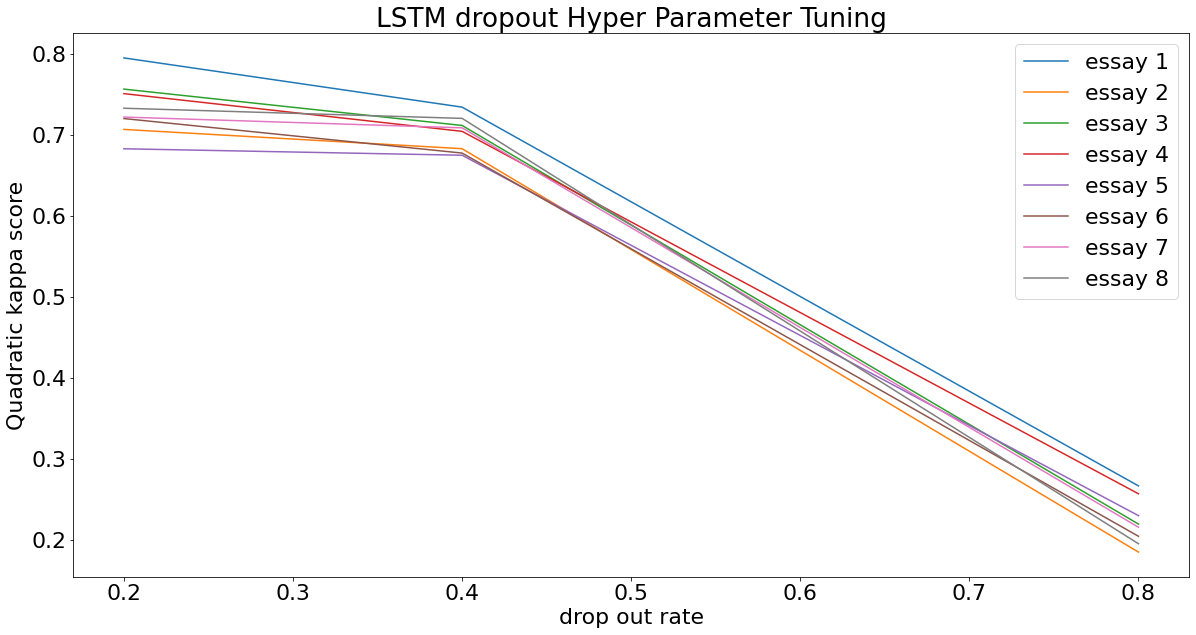

In [47]:
new_d = {}
result = []
plt.rcParams.update({'font.size': 22})
for i in range(1,9):
    new_d[str(i)] = {}
    result_array = []
    for dropout in dropouts:
        new_d[str(i)][str(dropout)] = []
        for neuron in neurons:
            new_d[str(i)][str(dropout)].append(d[str(i)][str(neuron)][str(dropout)])
        new_d[str(i)][str(dropout)] = np.mean(new_d[str(i)][str(dropout)])
        result_array.append(np.mean(new_d[str(i)][str(dropout)]))
    result.append(result_array)
fig, ax = plt.subplots(figsize = (20,10))
legends = []
for i in range(1,9):
    ax.plot(dropouts, result[i-1])
    string = "essay " + str(i)
    legends.append(string)
ax.legend(legends)
ax.set_xlabel("drop out rate")
ax.set_ylabel("Quadratic kappa score")
ax.set_title("LSTM dropout Hyper Parameter Tuning")
fig.savefig("lstm_dropout_hyper_parameter_tuning.png")

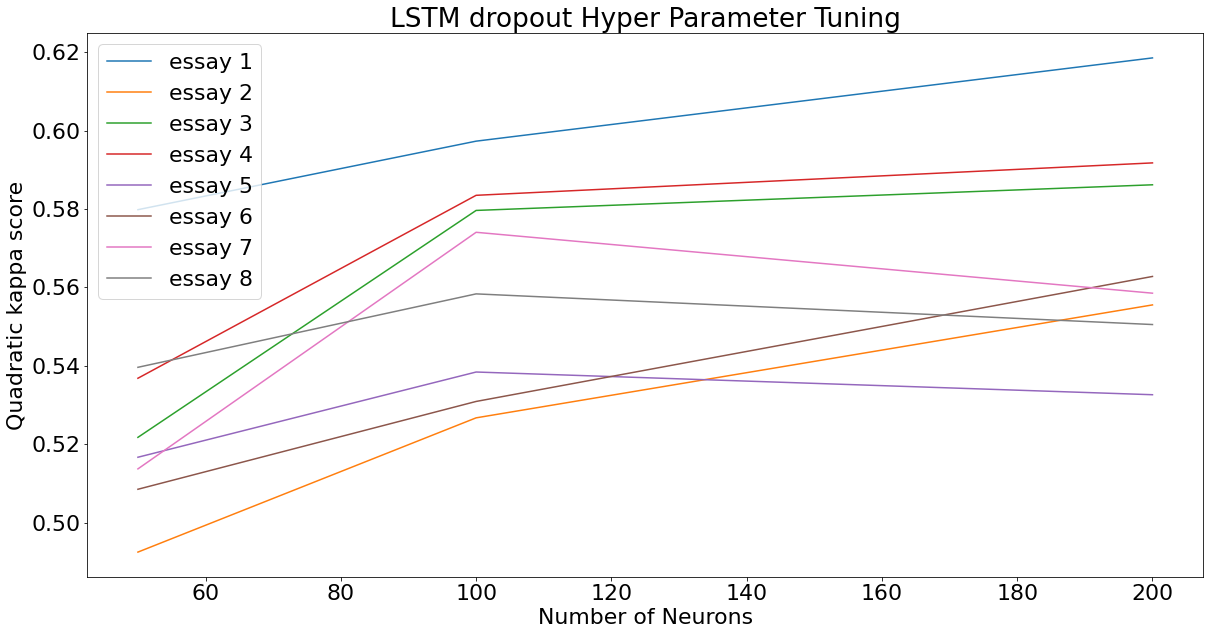

In [45]:
new_d = {}
result = []
plt.rcParams.update({'font.size': 22})
for i in range(1,9):
    new_d[str(i)] = {}
    result_array = []
    for neuron in neurons:
        new_d[str(i)][str(neuron)] = []
        for dropout in dropouts:
            new_d[str(i)][str(neuron)].append(d[str(i)][str(neuron)][str(dropout)])
        new_d[str(i)][str(neuron)] = np.mean(new_d[str(i)][str(neuron)])
        result_array.append(np.mean(new_d[str(i)][str(neuron)]))
    result.append(result_array)
fig, ax = plt.subplots(figsize = (20,10))
legends = []
for i in range(1,9):
    ax.plot(neurons, result[i-1])
    string = "essay " + str(i)
    legends.append(string)
ax.legend(legends)
ax.set_xlabel("Number of Neurons")
ax.set_ylabel("Quadratic kappa score")
ax.set_title("LSTM dropout Hyper Parameter Tuning")
fig.savefig("lstm_neurons_hyperparameter_tuning.png")

In [49]:
for i in range(1,9):
    print("Essay set " + str(i))
    print(d[str(i)]["200"]["0.2"])

Essay set 1
0.7963777815429541
Essay set 2
0.7042569408784093
Essay set 3
0.7483292893148542
Essay set 4
0.7292880118116293
Essay set 5
0.672460309581742
Essay set 6
0.7247463231238779
Essay set 7
0.7131959981086414
Essay set 8
0.7276339272341596


## TOMS SECTION

In [10]:

def build_model(length):
    model = Sequential([
        #tune these layers
        Dense(128, activation=tf.nn.relu, input_shape=[length]),
        Dense(128, activation=tf.nn.relu),
        Dense(128, activation=tf.nn.relu),
        Dense(1)
    ])
    optimizer =  tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss="mse",
                 optimizer=optimizer,
                 metrics=["mae","mse"])
    
    return model
  

In [11]:
cv = KFold(n_splits = 5, shuffle = True)
results = []
r2s = []
mses = []
y_pred_list = []
count = 1

for num in range(1,9):
    essay_set = pd.read_csv("../dataset/cleandata_set_{}.csv".format(num))
    train_corpus = essay_set['essay']
    test_corpus = train_corpus.copy()
    vocab = CountVectorizer(stop_words='english', lowercase= True).fit(train_corpus)

    # generate counts for a new set of documents
    doc_emb = vocab.transform(train_corpus)
    
    vec_size = 50
    window=2
    min_count=1
    workers=8
    epochs=40
    essays = [TaggedDocument(gensim.utils.simple_preprocess(doc), [i]) for i, doc in enumerate(train_corpus)]
    
    model = Doc2Vec(essays, vector_size=vec_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
    #might not need this line
    model.train(essays, total_examples=model.corpus_count, epochs=model.epochs)
    doc = [gensim.utils.simple_preprocess(doc) for i, doc in enumerate(test_corpus)]

    doc_emb = np.zeros((len(doc), vec_size))
    for i in range(len(doc)):
        doc_emb[i,:] = model.infer_vector(doc[i])
        
    df_train = pd.DataFrame(doc_emb)
    df_train = pd.concat([df_train, df[["essay_set", "word_count","Mistakes","reading_ease"]]], axis = 1, join = "inner")
    
    y = df["total_score"]
    X = df_train
    print("\n###########Set-{}###########\n".format(num))
    count = 1
    result_for_set = []
    for traincv, testcv in cv.split(X):
        print("\n--------Fold {}--------\n".format(count))
        
        X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()

        #X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
        #X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
        
        early_stop = EarlyStopping(monitor="val_loss", patience=100)
        
        lstm_model = build_model(len(X_train[0]))
        lstm_model.fit(X_train, y_train, validation_split=0.2, epochs=1000, batch_size=32,callbacks=[early_stop])
        
        y_pred_temp = lstm_model.predict(X_test)

        y_pred = []
        for i in y_pred_temp:
            y_pred.append(int(round(i[0])))
        y_pred_temp = np.around(y_pred_temp)
        if count == 5:
             lstm_model.save_weights('final_lstm.h5')
        y_test_new = []
        for  i in list(y_test.array):
            y_test_new.append(int(i))
        result = cohen_kappa_score(y_test_new,y_pred,weights='quadratic')
        print("Kappa Score: {}".format(result))
        result_for_set.append(result)
        count += 1
    results.append(result_for_set)


###########Set-1###########


--------Fold 1--------

Epoch 1/1000
36/36 [==============================] - 0s 3ms/step - loss: 183.9047 - mae: 5.8832 - mse: 183.9047 - val_loss: 5.8881 - val_mae: 2.2037 - val_mse: 5.8881
Epoch 2/1000
36/36 [==============================] - 0s 1ms/step - loss: 57.7236 - mae: 5.8763 - mse: 57.7236 - val_loss: 12.3643 - val_mae: 2.9653 - val_mse: 12.3643
Epoch 3/1000
36/36 [==============================] - 0s 1ms/step - loss: 23.3152 - mae: 4.1832 - mse: 23.3152 - val_loss: 20.9764 - val_mae: 4.0151 - val_mse: 20.9764
Epoch 4/1000
36/36 [==============================] - 0s 1ms/step - loss: 14.4565 - mae: 3.1036 - mse: 14.4565 - val_loss: 1.5786 - val_mae: 0.9400 - val_mse: 1.5786
Epoch 5/1000
36/36 [==============================] - 0s 1ms/step - loss: 7.7410 - mae: 2.0343 - mse: 7.7410 - val_loss: 8.3589 - val_mae: 2.4571 - val_mse: 8.3589
Epoch 6/1000
36/36 [==============================] - 0s 1ms/step - loss: 5.6345 - mae: 1.7586 - mse: 5.6345 - 

Epoch 50/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8962 - mae: 0.7345 - mse: 0.8962 - val_loss: 0.7973 - val_mae: 0.6794 - val_mse: 0.7973
Epoch 51/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9324 - mae: 0.7663 - mse: 0.9324 - val_loss: 0.8548 - val_mae: 0.7171 - val_mse: 0.8548
Epoch 52/1000
36/36 [==============================] - 0s 997us/step - loss: 0.8407 - mae: 0.7233 - mse: 0.8407 - val_loss: 0.6786 - val_mae: 0.6312 - val_mse: 0.6786
Epoch 53/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8871 - mae: 0.7295 - mse: 0.8871 - val_loss: 0.6621 - val_mae: 0.6205 - val_mse: 0.6621
Epoch 54/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8846 - mae: 0.7336 - mse: 0.8846 - val_loss: 1.0040 - val_mae: 0.8046 - val_mse: 1.0040
Epoch 55/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8690 - mae: 0.7356 - mse: 0.8690 - val_loss: 2.1189 - val_mae: 1.2535 - val_mse: 2.1189
Epoch 56

36/36 [==============================] - 0s 1ms/step - loss: 0.5648 - mae: 0.5807 - mse: 0.5648 - val_loss: 0.7739 - val_mae: 0.6708 - val_mse: 0.7739
Epoch 149/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5191 - mae: 0.5548 - mse: 0.5191 - val_loss: 0.8249 - val_mae: 0.7003 - val_mse: 0.8249
Epoch 150/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5497 - mae: 0.5661 - mse: 0.5497 - val_loss: 0.8299 - val_mae: 0.7108 - val_mse: 0.8299
Epoch 151/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5228 - mae: 0.5528 - mse: 0.5228 - val_loss: 1.0581 - val_mae: 0.8388 - val_mse: 1.0581
Epoch 152/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5564 - mae: 0.5799 - mse: 0.5564 - val_loss: 0.7547 - val_mae: 0.6593 - val_mse: 0.7547
Epoch 153/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5341 - mae: 0.5724 - mse: 0.5341 - val_loss: 0.8815 - val_mae: 0.7227 - val_mse: 0.8815
Epoch 154/1000
36/3

36/36 [==============================] - 0s 1ms/step - loss: 0.7835 - mae: 0.6932 - mse: 0.7835 - val_loss: 0.6134 - val_mae: 0.6157 - val_mse: 0.6134
Epoch 81/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7663 - mae: 0.6843 - mse: 0.7663 - val_loss: 0.8679 - val_mae: 0.7352 - val_mse: 0.8679
Epoch 82/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7729 - mae: 0.6896 - mse: 0.7729 - val_loss: 1.0182 - val_mae: 0.8037 - val_mse: 1.0182
Epoch 83/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8276 - mae: 0.7047 - mse: 0.8276 - val_loss: 0.6073 - val_mae: 0.6220 - val_mse: 0.6073
Epoch 84/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7856 - mae: 0.6931 - mse: 0.7856 - val_loss: 0.6855 - val_mae: 0.6480 - val_mse: 0.6855
Epoch 85/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8078 - mae: 0.7004 - mse: 0.8078 - val_loss: 0.6366 - val_mae: 0.6260 - val_mse: 0.6366
Epoch 86/1000
36/36 [===

36/36 [==============================] - 0s 1ms/step - loss: 0.5412 - mae: 0.5685 - mse: 0.5412 - val_loss: 0.7432 - val_mae: 0.6763 - val_mse: 0.7432
Epoch 179/1000
36/36 [==============================] - 0s 997us/step - loss: 0.5214 - mae: 0.5583 - mse: 0.5214 - val_loss: 0.8663 - val_mae: 0.7604 - val_mse: 0.8663
Epoch 180/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5466 - mae: 0.5730 - mse: 0.5466 - val_loss: 0.7009 - val_mae: 0.6533 - val_mse: 0.7009
Epoch 181/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5279 - mae: 0.5673 - mse: 0.5279 - val_loss: 0.7028 - val_mae: 0.6670 - val_mse: 0.7028
Epoch 182/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.4940 - mae: 0.5415 - mse: 0.4940 - val_loss: 0.7160 - val_mae: 0.6546 - val_mse: 0.7160
Epoch 183/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5187 - mae: 0.5578 - mse: 0.5187 - val_loss: 0.7552 - val_mae: 0.6820 - val_mse: 0.7552
Kappa Score: 0.84

Epoch 43/1000
36/36 [==============================] - 0s 1000us/step - loss: 0.9411 - mae: 0.7659 - mse: 0.9411 - val_loss: 1.4912 - val_mae: 0.9977 - val_mse: 1.4912
Epoch 44/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9299 - mae: 0.7554 - mse: 0.9299 - val_loss: 1.6022 - val_mae: 1.0455 - val_mse: 1.6022
Epoch 45/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9496 - mae: 0.7580 - mse: 0.9496 - val_loss: 0.8371 - val_mae: 0.7366 - val_mse: 0.8371
Epoch 46/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0464 - mae: 0.8146 - mse: 1.0464 - val_loss: 0.8429 - val_mae: 0.7295 - val_mse: 0.8429
Epoch 47/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9443 - mae: 0.7608 - mse: 0.9443 - val_loss: 0.7676 - val_mae: 0.7046 - val_mse: 0.7676
Epoch 48/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9234 - mae: 0.7493 - mse: 0.9234 - val_loss: 0.7698 - val_mae: 0.7050 - val_mse: 0.7698
Epoch 4

36/36 [==============================] - 0s 1ms/step - loss: 0.5415 - mae: 0.5579 - mse: 0.5415 - val_loss: 0.8111 - val_mae: 0.6863 - val_mse: 0.8111
Epoch 142/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6178 - mae: 0.6044 - mse: 0.6178 - val_loss: 0.9890 - val_mae: 0.8084 - val_mse: 0.9890
Epoch 143/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5788 - mae: 0.5920 - mse: 0.5788 - val_loss: 1.2538 - val_mae: 0.9160 - val_mse: 1.2538
Epoch 144/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5840 - mae: 0.5955 - mse: 0.5840 - val_loss: 1.2098 - val_mae: 0.8675 - val_mse: 1.2098
Epoch 145/1000
36/36 [==============================] - 0s 997us/step - loss: 0.5869 - mae: 0.5983 - mse: 0.5869 - val_loss: 0.7581 - val_mae: 0.6805 - val_mse: 0.7581
Epoch 146/1000
36/36 [==============================] - 0s 993us/step - loss: 0.5653 - mae: 0.5936 - mse: 0.5653 - val_loss: 0.7805 - val_mae: 0.6716 - val_mse: 0.7805
Epoch 147/1000


36/36 [==============================] - 0s 997us/step - loss: 2.8375 - mae: 1.3545 - mse: 2.8375 - val_loss: 1.1647 - val_mae: 0.8161 - val_mse: 1.1647
Epoch 8/1000
36/36 [==============================] - 0s 1ms/step - loss: 2.6182 - mae: 1.2825 - mse: 2.6182 - val_loss: 4.3171 - val_mae: 1.8950 - val_mse: 4.3171
Epoch 9/1000
36/36 [==============================] - 0s 1ms/step - loss: 2.4175 - mae: 1.2500 - mse: 2.4175 - val_loss: 0.9945 - val_mae: 0.7573 - val_mse: 0.9945
Epoch 10/1000
36/36 [==============================] - 0s 1ms/step - loss: 2.0836 - mae: 1.1693 - mse: 2.0836 - val_loss: 1.1559 - val_mae: 0.8225 - val_mse: 1.1559
Epoch 11/1000
36/36 [==============================] - 0s 1ms/step - loss: 2.0261 - mae: 1.1402 - mse: 2.0261 - val_loss: 0.8371 - val_mae: 0.7121 - val_mse: 0.8371
Epoch 12/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.9812 - mae: 1.0914 - mse: 1.9812 - val_loss: 1.5048 - val_mae: 1.0140 - val_mse: 1.5048
Epoch 13/1000
36/36 [===

Epoch 57/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8709 - mae: 0.7365 - mse: 0.8709 - val_loss: 1.2432 - val_mae: 0.9187 - val_mse: 1.2432
Epoch 58/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8705 - mae: 0.7368 - mse: 0.8705 - val_loss: 0.7997 - val_mae: 0.7189 - val_mse: 0.7997
Epoch 59/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8244 - mae: 0.7079 - mse: 0.8244 - val_loss: 0.7393 - val_mae: 0.6917 - val_mse: 0.7393
Epoch 60/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9005 - mae: 0.7384 - mse: 0.9005 - val_loss: 0.9233 - val_mae: 0.7683 - val_mse: 0.9233
Epoch 61/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8319 - mae: 0.7235 - mse: 0.8319 - val_loss: 1.3729 - val_mae: 0.9755 - val_mse: 1.3729
Epoch 62/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8333 - mae: 0.7276 - mse: 0.8333 - val_loss: 1.2885 - val_mae: 0.8924 - val_mse: 1.2885
Epoch 63/1

36/36 [==============================] - 0s 1ms/step - loss: 18.0991 - mae: 3.2103 - mse: 18.0991 - val_loss: 3.8193 - val_mae: 1.7213 - val_mse: 3.8193
Epoch 3/1000
36/36 [==============================] - 0s 1ms/step - loss: 11.7180 - mae: 2.6165 - mse: 11.7180 - val_loss: 3.2135 - val_mae: 1.4540 - val_mse: 3.2135
Epoch 4/1000
36/36 [==============================] - 0s 1ms/step - loss: 6.9048 - mae: 2.0563 - mse: 6.9048 - val_loss: 2.2961 - val_mae: 1.1334 - val_mse: 2.2961
Epoch 5/1000
36/36 [==============================] - 0s 1ms/step - loss: 4.3975 - mae: 1.6925 - mse: 4.3975 - val_loss: 11.2834 - val_mae: 3.1897 - val_mse: 11.2834
Epoch 6/1000
36/36 [==============================] - 0s 1ms/step - loss: 3.2432 - mae: 1.4451 - mse: 3.2432 - val_loss: 1.9366 - val_mae: 1.1608 - val_mse: 1.9366
Epoch 7/1000
36/36 [==============================] - 0s 1ms/step - loss: 2.6041 - mae: 1.2782 - mse: 2.6041 - val_loss: 0.9956 - val_mae: 0.7696 - val_mse: 0.9956
Epoch 8/1000
36/36 [===

Epoch 52/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7907 - mae: 0.7024 - mse: 0.7907 - val_loss: 0.8556 - val_mae: 0.7187 - val_mse: 0.8556
Epoch 53/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8456 - mae: 0.7164 - mse: 0.8456 - val_loss: 0.9392 - val_mae: 0.7643 - val_mse: 0.9392
Epoch 54/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8753 - mae: 0.7342 - mse: 0.8753 - val_loss: 0.9438 - val_mae: 0.7686 - val_mse: 0.9438
Epoch 55/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8184 - mae: 0.7140 - mse: 0.8184 - val_loss: 0.7180 - val_mae: 0.6792 - val_mse: 0.7180
Epoch 56/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7739 - mae: 0.6978 - mse: 0.7739 - val_loss: 0.8689 - val_mae: 0.7441 - val_mse: 0.8689
Epoch 57/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8942 - mae: 0.7397 - mse: 0.8942 - val_loss: 1.0205 - val_mae: 0.8260 - val_mse: 1.0205
Epoch 58/1

Epoch 102/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6731 - mae: 0.6338 - mse: 0.6731 - val_loss: 1.0495 - val_mae: 0.8104 - val_mse: 1.0495
Epoch 103/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6826 - mae: 0.6335 - mse: 0.6826 - val_loss: 1.3320 - val_mae: 0.9713 - val_mse: 1.3320
Epoch 104/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6605 - mae: 0.6256 - mse: 0.6605 - val_loss: 0.6610 - val_mae: 0.6423 - val_mse: 0.6610
Epoch 105/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6603 - mae: 0.6309 - mse: 0.6603 - val_loss: 0.7298 - val_mae: 0.6588 - val_mse: 0.7298
Epoch 106/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6412 - mae: 0.6088 - mse: 0.6412 - val_loss: 1.1751 - val_mae: 0.8921 - val_mse: 1.1751
Epoch 107/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6776 - mae: 0.6419 - mse: 0.6776 - val_loss: 0.6700 - val_mae: 0.6556 - val_mse: 0.6700
Epoc

Epoch 31/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3692 - mae: 0.9131 - mse: 1.3692 - val_loss: 4.1621 - val_mae: 1.0538 - val_mse: 4.1621
Epoch 32/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3434 - mae: 0.9094 - mse: 1.3434 - val_loss: 2.5374 - val_mae: 1.0030 - val_mse: 2.5374
Epoch 33/1000
36/36 [==============================] - 0s 997us/step - loss: 1.3971 - mae: 0.9300 - mse: 1.3971 - val_loss: 4.5184 - val_mae: 1.0695 - val_mse: 4.5184
Epoch 34/1000
36/36 [==============================] - 0s 942us/step - loss: 1.4417 - mae: 0.9523 - mse: 1.4417 - val_loss: 3.1583 - val_mae: 1.0137 - val_mse: 3.1583
Epoch 35/1000
36/36 [==============================] - 0s 970us/step - loss: 1.2644 - mae: 0.8734 - mse: 1.2644 - val_loss: 5.3976 - val_mae: 1.0669 - val_mse: 5.3976
Epoch 36/1000
36/36 [==============================] - 0s 942us/step - loss: 1.4174 - mae: 0.9345 - mse: 1.4174 - val_loss: 3.0231 - val_mae: 1.0662 - val_mse: 3.0231
Ep

36/36 [==============================] - 0s 997us/step - loss: 0.7867 - mae: 0.6929 - mse: 0.7867 - val_loss: 3.1356 - val_mae: 1.0605 - val_mse: 3.1356
Epoch 130/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7943 - mae: 0.6962 - mse: 0.7943 - val_loss: 2.6281 - val_mae: 1.0504 - val_mse: 2.6281
Epoch 131/1000
36/36 [==============================] - 0s 970us/step - loss: 0.7736 - mae: 0.6731 - mse: 0.7736 - val_loss: 3.0193 - val_mae: 1.0704 - val_mse: 3.0193
Epoch 132/1000
36/36 [==============================] - 0s 970us/step - loss: 0.8033 - mae: 0.6879 - mse: 0.8033 - val_loss: 2.9110 - val_mae: 1.0431 - val_mse: 2.9110
Epoch 133/1000
36/36 [==============================] - 0s 998us/step - loss: 0.7198 - mae: 0.6484 - mse: 0.7198 - val_loss: 3.1323 - val_mae: 1.0891 - val_mse: 3.1323
Epoch 134/1000
36/36 [==============================] - 0s 942us/step - loss: 0.7565 - mae: 0.6627 - mse: 0.7565 - val_loss: 3.0046 - val_mae: 1.0366 - val_mse: 3.0046
Epoch 135

Epoch 178/1000
36/36 [==============================] - 0s 970us/step - loss: 0.5611 - mae: 0.5762 - mse: 0.5611 - val_loss: 2.9551 - val_mae: 1.0364 - val_mse: 2.9551
Epoch 179/1000
36/36 [==============================] - 0s 997us/step - loss: 0.5889 - mae: 0.5961 - mse: 0.5889 - val_loss: 2.8822 - val_mae: 1.0423 - val_mse: 2.8822
Epoch 180/1000
36/36 [==============================] - 0s 942us/step - loss: 0.5653 - mae: 0.5748 - mse: 0.5653 - val_loss: 2.6432 - val_mae: 1.0384 - val_mse: 2.6432
Epoch 181/1000
36/36 [==============================] - 0s 970us/step - loss: 0.6017 - mae: 0.5963 - mse: 0.6017 - val_loss: 3.7541 - val_mae: 1.1978 - val_mse: 3.7541
Epoch 182/1000
36/36 [==============================] - 0s 997us/step - loss: 0.5711 - mae: 0.5686 - mse: 0.5711 - val_loss: 3.9752 - val_mae: 1.2001 - val_mse: 3.9752
Epoch 183/1000
36/36 [==============================] - 0s 997us/step - loss: 0.5896 - mae: 0.5918 - mse: 0.5896 - val_loss: 2.8822 - val_mae: 1.1434 - val_mse:

Epoch 19/1000
36/36 [==============================] - 0s 914us/step - loss: 1.6669 - mae: 1.0093 - mse: 1.6669 - val_loss: 2.5039 - val_mae: 1.1570 - val_mse: 2.5039
Epoch 20/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.5587 - mae: 0.9890 - mse: 1.5587 - val_loss: 4.1346 - val_mae: 1.0484 - val_mse: 4.1346
Epoch 21/1000
36/36 [==============================] - 0s 997us/step - loss: 1.5504 - mae: 0.9784 - mse: 1.5504 - val_loss: 1.9875 - val_mae: 1.0015 - val_mse: 1.9875
Epoch 22/1000
36/36 [==============================] - 0s 969us/step - loss: 1.5057 - mae: 0.9604 - mse: 1.5057 - val_loss: 2.4884 - val_mae: 1.0157 - val_mse: 2.4884
Epoch 23/1000
36/36 [==============================] - 0s 997us/step - loss: 1.5318 - mae: 0.9709 - mse: 1.5318 - val_loss: 5.0368 - val_mae: 1.0410 - val_mse: 5.0368
Epoch 24/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.4972 - mae: 0.9684 - mse: 1.4972 - val_loss: 4.0686 - val_mae: 1.4365 - val_mse: 4.0686
Ep

36/36 [==============================] - 0s 1ms/step - loss: 0.7534 - mae: 0.6762 - mse: 0.7534 - val_loss: 3.4091 - val_mae: 1.2656 - val_mse: 3.4091
Epoch 118/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8748 - mae: 0.7221 - mse: 0.8748 - val_loss: 2.2889 - val_mae: 0.9679 - val_mse: 2.2889
Epoch 119/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8443 - mae: 0.7045 - mse: 0.8443 - val_loss: 2.3564 - val_mae: 0.9958 - val_mse: 2.3564
Epoch 120/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7803 - mae: 0.6808 - mse: 0.7803 - val_loss: 2.2087 - val_mae: 1.0332 - val_mse: 2.2087
Epoch 121/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8163 - mae: 0.6930 - mse: 0.8163 - val_loss: 2.9004 - val_mae: 1.0511 - val_mse: 2.9004
Epoch 122/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8090 - mae: 0.6890 - mse: 0.8090 - val_loss: 2.1206 - val_mae: 1.0153 - val_mse: 2.1206
Epoch 123/1000
36/3

Epoch 80/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9409 - mae: 0.7429 - mse: 0.9409 - val_loss: 2.9075 - val_mae: 1.0996 - val_mse: 2.9075
Epoch 81/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9493 - mae: 0.7525 - mse: 0.9493 - val_loss: 3.4367 - val_mae: 1.1180 - val_mse: 3.4367
Epoch 82/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9495 - mae: 0.7417 - mse: 0.9495 - val_loss: 3.1443 - val_mae: 1.0710 - val_mse: 3.1443
Epoch 83/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9149 - mae: 0.7436 - mse: 0.9149 - val_loss: 3.5830 - val_mae: 1.2004 - val_mse: 3.5830
Epoch 84/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9023 - mae: 0.7231 - mse: 0.9023 - val_loss: 3.4394 - val_mae: 1.1233 - val_mse: 3.4394
Epoch 85/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8920 - mae: 0.7190 - mse: 0.8920 - val_loss: 2.6975 - val_mae: 1.0482 - val_mse: 2.6975
Epoch 86/1

36/36 [==============================] - 0s 1ms/step - loss: 0.5827 - mae: 0.5808 - mse: 0.5827 - val_loss: 2.6748 - val_mae: 1.1529 - val_mse: 2.6748
Epoch 179/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5659 - mae: 0.5669 - mse: 0.5659 - val_loss: 3.0901 - val_mae: 1.1358 - val_mse: 3.0901
Epoch 180/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5375 - mae: 0.5637 - mse: 0.5375 - val_loss: 4.0729 - val_mae: 1.3312 - val_mse: 4.0729
Epoch 181/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.4982 - mae: 0.5344 - mse: 0.4982 - val_loss: 2.9131 - val_mae: 1.2072 - val_mse: 2.9131
Epoch 182/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5514 - mae: 0.5722 - mse: 0.5514 - val_loss: 4.1042 - val_mae: 1.3141 - val_mse: 4.1042
Epoch 183/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5112 - mae: 0.5412 - mse: 0.5112 - val_loss: 2.6821 - val_mae: 1.1086 - val_mse: 2.6821
Epoch 184/1000
36/3

Epoch 38/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2388 - mae: 0.8535 - mse: 1.2388 - val_loss: 33.6646 - val_mae: 1.4497 - val_mse: 33.6646
Epoch 39/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2983 - mae: 0.8758 - mse: 1.2983 - val_loss: 26.0674 - val_mae: 1.3715 - val_mse: 26.0674
Epoch 40/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2006 - mae: 0.8542 - mse: 1.2006 - val_loss: 20.4124 - val_mae: 1.5706 - val_mse: 20.4124
Epoch 41/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3214 - mae: 0.8862 - mse: 1.3214 - val_loss: 15.8967 - val_mae: 1.3534 - val_mse: 15.8967
Epoch 42/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2682 - mae: 0.8594 - mse: 1.2682 - val_loss: 20.8450 - val_mae: 1.3336 - val_mse: 20.8450
Epoch 43/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2507 - mae: 0.8632 - mse: 1.2507 - val_loss: 18.4646 - val_mae: 1.3067 - val_mse: 18.464

36/36 [==============================] - 0s 1ms/step - loss: 0.9882 - mae: 0.7698 - mse: 0.9882 - val_loss: 18.8788 - val_mae: 1.2696 - val_mse: 18.8788
Epoch 88/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9513 - mae: 0.7471 - mse: 0.9513 - val_loss: 19.0749 - val_mae: 1.4563 - val_mse: 19.0749
Epoch 89/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0160 - mae: 0.7705 - mse: 1.0160 - val_loss: 17.6195 - val_mae: 1.4290 - val_mse: 17.6195
Epoch 90/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9804 - mae: 0.7648 - mse: 0.9804 - val_loss: 17.2605 - val_mae: 1.3509 - val_mse: 17.2605
Epoch 91/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9730 - mae: 0.7394 - mse: 0.9730 - val_loss: 17.6970 - val_mae: 1.3397 - val_mse: 17.6970
Epoch 92/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9898 - mae: 0.7682 - mse: 0.9898 - val_loss: 20.6559 - val_mae: 1.3476 - val_mse: 20.6559
Epoch 93/100

36/36 [==============================] - 0s 1ms/step - loss: 1.4405 - mae: 0.9318 - mse: 1.4405 - val_loss: 2.2409 - val_mae: 0.9275 - val_mse: 2.2409
Epoch 32/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2291 - mae: 0.8695 - mse: 1.2291 - val_loss: 1.9997 - val_mae: 0.8807 - val_mse: 1.9997
Epoch 33/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3709 - mae: 0.9158 - mse: 1.3709 - val_loss: 2.7189 - val_mae: 1.2266 - val_mse: 2.7189
Epoch 34/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3021 - mae: 0.8925 - mse: 1.3021 - val_loss: 2.2961 - val_mae: 0.9585 - val_mse: 2.2961
Epoch 35/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3493 - mae: 0.9073 - mse: 1.3493 - val_loss: 2.9982 - val_mae: 1.1141 - val_mse: 2.9982
Epoch 36/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3303 - mae: 0.8883 - mse: 1.3303 - val_loss: 2.0615 - val_mae: 0.8929 - val_mse: 2.0615
Epoch 37/1000
36/36 [===

36/36 [==============================] - 0s 1ms/step - loss: 0.7943 - mae: 0.6801 - mse: 0.7943 - val_loss: 2.0470 - val_mae: 0.9331 - val_mse: 2.0470
Epoch 130/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7847 - mae: 0.6802 - mse: 0.7847 - val_loss: 1.9438 - val_mae: 0.9226 - val_mse: 1.9438
Epoch 131/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7807 - mae: 0.6682 - mse: 0.7807 - val_loss: 2.0399 - val_mae: 0.8952 - val_mse: 2.0399
Epoch 132/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7263 - mae: 0.6458 - mse: 0.7263 - val_loss: 2.4500 - val_mae: 1.0206 - val_mse: 2.4500
Epoch 133/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7712 - mae: 0.6620 - mse: 0.7712 - val_loss: 1.9736 - val_mae: 0.8823 - val_mse: 1.9736
Epoch 134/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7483 - mae: 0.6555 - mse: 0.7483 - val_loss: 1.9698 - val_mae: 0.8771 - val_mse: 1.9698
Epoch 135/1000
36/3

36/36 [==============================] - 0s 1ms/step - loss: 0.4913 - mae: 0.5276 - mse: 0.4913 - val_loss: 2.1171 - val_mae: 0.9606 - val_mse: 2.1171
Epoch 228/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.4813 - mae: 0.5268 - mse: 0.4813 - val_loss: 1.9836 - val_mae: 0.9394 - val_mse: 1.9836
Epoch 229/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.4722 - mae: 0.5124 - mse: 0.4722 - val_loss: 2.2563 - val_mae: 0.9751 - val_mse: 2.2563
Epoch 230/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.4759 - mae: 0.5220 - mse: 0.4759 - val_loss: 1.9047 - val_mae: 0.9517 - val_mse: 1.9047
Epoch 231/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.4560 - mae: 0.5071 - mse: 0.4560 - val_loss: 2.0925 - val_mae: 0.9593 - val_mse: 2.0925
Epoch 232/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.4493 - mae: 0.5055 - mse: 0.4493 - val_loss: 1.9310 - val_mae: 0.9328 - val_mse: 1.9310
Epoch 233/1000
36/3

35/35 [==============================] - 0s 3ms/step - loss: 90.6478 - mae: 5.3477 - mse: 90.6478 - val_loss: 26.3299 - val_mae: 4.6149 - val_mse: 26.3299
Epoch 2/1000
35/35 [==============================] - 0s 2ms/step - loss: 19.2094 - mae: 2.9639 - mse: 19.2094 - val_loss: 60.6997 - val_mae: 7.1748 - val_mse: 60.6997
Epoch 3/1000
35/35 [==============================] - 0s 1ms/step - loss: 13.2253 - mae: 2.8205 - mse: 13.2253 - val_loss: 1.5482 - val_mae: 0.9720 - val_mse: 1.5482
Epoch 4/1000
35/35 [==============================] - 0s 1ms/step - loss: 8.4639 - mae: 2.3448 - mse: 8.4639 - val_loss: 9.9766 - val_mae: 2.9526 - val_mse: 9.9766
Epoch 5/1000
35/35 [==============================] - 0s 1ms/step - loss: 4.4050 - mae: 1.6623 - mse: 4.4050 - val_loss: 6.2763 - val_mae: 2.1882 - val_mse: 6.2763
Epoch 6/1000
35/35 [==============================] - 0s 1ms/step - loss: 3.7182 - mae: 1.5454 - mse: 3.7182 - val_loss: 1.2573 - val_mae: 0.8495 - val_mse: 1.2573
Epoch 7/1000
35/35 

Epoch 51/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.1249 - mae: 0.8324 - mse: 1.1249 - val_loss: 0.9104 - val_mae: 0.7544 - val_mse: 0.9104
Epoch 52/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.1781 - mae: 0.8338 - mse: 1.1781 - val_loss: 1.5373 - val_mae: 1.0088 - val_mse: 1.5373
Epoch 53/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2153 - mae: 0.8630 - mse: 1.2153 - val_loss: 1.2887 - val_mae: 0.8845 - val_mse: 1.2887
Epoch 54/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2153 - mae: 0.8569 - mse: 1.2153 - val_loss: 1.1999 - val_mae: 0.8804 - val_mse: 1.1999
Epoch 55/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.1974 - mae: 0.8503 - mse: 1.1974 - val_loss: 1.4955 - val_mae: 0.9928 - val_mse: 1.4955
Epoch 56/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2343 - mae: 0.8620 - mse: 1.2343 - val_loss: 0.8462 - val_mae: 0.7163 - val_mse: 0.8462
Epoch 57/1

Epoch 101/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9590 - mae: 0.7551 - mse: 0.9590 - val_loss: 1.2205 - val_mae: 0.8964 - val_mse: 1.2205
Epoch 102/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.8723 - mae: 0.7132 - mse: 0.8723 - val_loss: 1.1423 - val_mae: 0.8603 - val_mse: 1.1423
Epoch 103/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9468 - mae: 0.7370 - mse: 0.9468 - val_loss: 0.9489 - val_mae: 0.7842 - val_mse: 0.9489
Epoch 104/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.8922 - mae: 0.7204 - mse: 0.8922 - val_loss: 1.6378 - val_mae: 1.0610 - val_mse: 1.6378
Epoch 105/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9352 - mae: 0.7302 - mse: 0.9352 - val_loss: 1.0229 - val_mae: 0.7911 - val_mse: 1.0229
Epoch 106/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.8739 - mae: 0.7044 - mse: 0.8739 - val_loss: 0.8551 - val_mae: 0.7176 - val_mse: 0.8551
Epoc

35/35 [==============================] - 0s 1ms/step - loss: 0.6544 - mae: 0.6074 - mse: 0.6544 - val_loss: 0.9242 - val_mae: 0.7599 - val_mse: 0.9242
Epoch 200/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6395 - mae: 0.5970 - mse: 0.6395 - val_loss: 1.3358 - val_mae: 0.9424 - val_mse: 1.3358
Epoch 201/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6891 - mae: 0.6198 - mse: 0.6891 - val_loss: 0.7874 - val_mae: 0.6965 - val_mse: 0.7874
Epoch 202/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6568 - mae: 0.6119 - mse: 0.6568 - val_loss: 0.9075 - val_mae: 0.7412 - val_mse: 0.9075
Epoch 203/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.7131 - mae: 0.6402 - mse: 0.7131 - val_loss: 0.7800 - val_mae: 0.6870 - val_mse: 0.7800
Epoch 204/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6454 - mae: 0.6103 - mse: 0.6454 - val_loss: 1.3980 - val_mae: 0.9720 - val_mse: 1.3980
Epoch 205/1000
35/3

35/35 [==============================] - 0s 997us/step - loss: 1.2686 - mae: 0.8780 - mse: 1.2686 - val_loss: 1.3919 - val_mae: 0.9344 - val_mse: 1.3919
Epoch 35/1000
35/35 [==============================] - 0s 969us/step - loss: 1.2791 - mae: 0.8944 - mse: 1.2791 - val_loss: 0.9846 - val_mae: 0.7734 - val_mse: 0.9846
Epoch 36/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.1683 - mae: 0.8554 - mse: 1.1683 - val_loss: 3.0269 - val_mae: 1.4351 - val_mse: 3.0269
Epoch 37/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.3718 - mae: 0.9006 - mse: 1.3718 - val_loss: 1.8529 - val_mae: 1.0829 - val_mse: 1.8529
Epoch 38/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2196 - mae: 0.8764 - mse: 1.2196 - val_loss: 1.0421 - val_mae: 0.8032 - val_mse: 1.0421
Epoch 39/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2644 - mae: 0.8923 - mse: 1.2644 - val_loss: 1.1506 - val_mae: 0.8462 - val_mse: 1.1506
Epoch 40/1000
35/35 

35/35 [==============================] - 0s 1ms/step - loss: 0.8707 - mae: 0.7149 - mse: 0.8707 - val_loss: 0.9499 - val_mae: 0.7576 - val_mse: 0.9499
Epoch 133/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.8043 - mae: 0.6947 - mse: 0.8043 - val_loss: 0.8278 - val_mae: 0.6872 - val_mse: 0.8278
Epoch 134/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9154 - mae: 0.7301 - mse: 0.9154 - val_loss: 0.8838 - val_mae: 0.7130 - val_mse: 0.8838
Epoch 135/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.8998 - mae: 0.7305 - mse: 0.8998 - val_loss: 0.8997 - val_mae: 0.7186 - val_mse: 0.8997
Epoch 136/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.8179 - mae: 0.6905 - mse: 0.8179 - val_loss: 1.4576 - val_mae: 0.9568 - val_mse: 1.4576
Epoch 137/1000
35/35 [==============================] - 0s 2ms/step - loss: 0.8671 - mae: 0.7176 - mse: 0.8671 - val_loss: 0.8585 - val_mae: 0.7070 - val_mse: 0.8585
Epoch 138/1000
35/3

35/35 [==============================] - 0s 1ms/step - loss: 0.5946 - mae: 0.5842 - mse: 0.5946 - val_loss: 0.8903 - val_mae: 0.7124 - val_mse: 0.8903
Epoch 231/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6264 - mae: 0.5932 - mse: 0.6264 - val_loss: 1.3509 - val_mae: 0.9123 - val_mse: 1.3509
Epoch 232/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.5939 - mae: 0.5866 - mse: 0.5939 - val_loss: 1.3220 - val_mae: 0.9031 - val_mse: 1.3220
Epoch 233/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6569 - mae: 0.6159 - mse: 0.6569 - val_loss: 1.0182 - val_mae: 0.7728 - val_mse: 1.0182
Epoch 234/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.5778 - mae: 0.5758 - mse: 0.5778 - val_loss: 1.2346 - val_mae: 0.8619 - val_mse: 1.2346
Epoch 235/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6354 - mae: 0.6077 - mse: 0.6354 - val_loss: 0.9130 - val_mae: 0.7126 - val_mse: 0.9130
Epoch 236/1000
35/3

35/35 [==============================] - 0s 997us/step - loss: 0.9627 - mae: 0.7618 - mse: 0.9627 - val_loss: 0.8648 - val_mae: 0.7271 - val_mse: 0.8648
Epoch 87/1000
35/35 [==============================] - 0s 997us/step - loss: 0.9056 - mae: 0.7412 - mse: 0.9056 - val_loss: 1.0130 - val_mae: 0.7954 - val_mse: 1.0130
Epoch 88/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9496 - mae: 0.7582 - mse: 0.9496 - val_loss: 1.3223 - val_mae: 0.9249 - val_mse: 1.3223
Epoch 89/1000
35/35 [==============================] - 0s 997us/step - loss: 0.9307 - mae: 0.7359 - mse: 0.9307 - val_loss: 1.0050 - val_mae: 0.8110 - val_mse: 1.0050
Epoch 90/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9387 - mae: 0.7513 - mse: 0.9387 - val_loss: 0.9010 - val_mae: 0.7511 - val_mse: 0.9010
Epoch 91/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9152 - mae: 0.7428 - mse: 0.9152 - val_loss: 1.1455 - val_mae: 0.8488 - val_mse: 1.1455
Epoch 92/1000
35/3

Epoch 135/1000
35/35 [==============================] - 0s 998us/step - loss: 0.7928 - mae: 0.6772 - mse: 0.7928 - val_loss: 0.7486 - val_mae: 0.6931 - val_mse: 0.7486
Epoch 136/1000
35/35 [==============================] - 0s 997us/step - loss: 0.7724 - mae: 0.6775 - mse: 0.7724 - val_loss: 0.7812 - val_mae: 0.7083 - val_mse: 0.7812
Epoch 137/1000
35/35 [==============================] - 0s 996us/step - loss: 0.7557 - mae: 0.6622 - mse: 0.7557 - val_loss: 0.9442 - val_mae: 0.7676 - val_mse: 0.9442
Epoch 138/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.8264 - mae: 0.6974 - mse: 0.8264 - val_loss: 0.9264 - val_mae: 0.7581 - val_mse: 0.9264
Epoch 139/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.7001 - mae: 0.6453 - mse: 0.7001 - val_loss: 0.7661 - val_mae: 0.7006 - val_mse: 0.7661
Epoch 140/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.7599 - mae: 0.6739 - mse: 0.7599 - val_loss: 0.7561 - val_mae: 0.6904 - val_mse: 0.756

35/35 [==============================] - 0s 1ms/step - loss: 0.4914 - mae: 0.5317 - mse: 0.4914 - val_loss: 0.9571 - val_mae: 0.7714 - val_mse: 0.9571
Epoch 234/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.5626 - mae: 0.5746 - mse: 0.5626 - val_loss: 0.8071 - val_mae: 0.7236 - val_mse: 0.8071
Epoch 235/1000
35/35 [==============================] - 0s 997us/step - loss: 0.5455 - mae: 0.5549 - mse: 0.5455 - val_loss: 0.7958 - val_mae: 0.7148 - val_mse: 0.7958
Epoch 236/1000
35/35 [==============================] - 0s 997us/step - loss: 0.4960 - mae: 0.5371 - mse: 0.4960 - val_loss: 1.0413 - val_mae: 0.7858 - val_mse: 1.0413
Epoch 237/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.5406 - mae: 0.5543 - mse: 0.5406 - val_loss: 1.0097 - val_mae: 0.8099 - val_mse: 1.0097
Epoch 238/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.5466 - mae: 0.5616 - mse: 0.5466 - val_loss: 0.8539 - val_mae: 0.7468 - val_mse: 0.8539
Epoch 239/1000


Epoch 32/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.4258 - mae: 0.9318 - mse: 1.4258 - val_loss: 1.1158 - val_mae: 0.8263 - val_mse: 1.1158
Epoch 33/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.3595 - mae: 0.9144 - mse: 1.3595 - val_loss: 1.5945 - val_mae: 1.0160 - val_mse: 1.5945
Epoch 34/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.4039 - mae: 0.9304 - mse: 1.4039 - val_loss: 1.1186 - val_mae: 0.8251 - val_mse: 1.1186
Epoch 35/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.3113 - mae: 0.9016 - mse: 1.3113 - val_loss: 2.2484 - val_mae: 1.2430 - val_mse: 2.2484
Epoch 36/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.4347 - mae: 0.9242 - mse: 1.4347 - val_loss: 1.6915 - val_mae: 1.0405 - val_mse: 1.6915
Epoch 37/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2608 - mae: 0.8748 - mse: 1.2608 - val_loss: 1.1198 - val_mae: 0.8310 - val_mse: 1.1198
Epoch 38/1

Epoch 82/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9474 - mae: 0.7555 - mse: 0.9474 - val_loss: 0.9314 - val_mae: 0.7588 - val_mse: 0.9314
Epoch 83/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0124 - mae: 0.7772 - mse: 1.0124 - val_loss: 0.8748 - val_mae: 0.7105 - val_mse: 0.8748
Epoch 84/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9550 - mae: 0.7520 - mse: 0.9550 - val_loss: 0.9099 - val_mae: 0.7481 - val_mse: 0.9099
Epoch 85/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9614 - mae: 0.7663 - mse: 0.9614 - val_loss: 1.3011 - val_mae: 0.9241 - val_mse: 1.3011
Epoch 86/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9644 - mae: 0.7644 - mse: 0.9644 - val_loss: 1.3752 - val_mae: 0.9351 - val_mse: 1.3752
Epoch 87/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9014 - mae: 0.7342 - mse: 0.9014 - val_loss: 0.9951 - val_mae: 0.7597 - val_mse: 0.9951
Epoch 88/1

35/35 [==============================] - 0s 1ms/step - loss: 0.6240 - mae: 0.6022 - mse: 0.6240 - val_loss: 0.9530 - val_mae: 0.7517 - val_mse: 0.9530
Epoch 181/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.5868 - mae: 0.5833 - mse: 0.5868 - val_loss: 0.8960 - val_mae: 0.7134 - val_mse: 0.8960
Epoch 182/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6067 - mae: 0.5925 - mse: 0.6067 - val_loss: 0.9709 - val_mae: 0.7794 - val_mse: 0.9709
Epoch 183/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6322 - mae: 0.6110 - mse: 0.6322 - val_loss: 1.8024 - val_mae: 1.1234 - val_mse: 1.8024
Epoch 184/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6520 - mae: 0.6160 - mse: 0.6520 - val_loss: 0.8543 - val_mae: 0.7147 - val_mse: 0.8543
Epoch 185/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.5912 - mae: 0.5865 - mse: 0.5912 - val_loss: 0.9195 - val_mae: 0.7324 - val_mse: 0.9195
Epoch 186/1000
35/3

35/35 [==============================] - 0s 1ms/step - loss: 1.4270 - mae: 0.9332 - mse: 1.4270 - val_loss: 2.1077 - val_mae: 1.1984 - val_mse: 2.1077
Epoch 39/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.2531 - mae: 0.8828 - mse: 1.2531 - val_loss: 0.9653 - val_mae: 0.7572 - val_mse: 0.9653
Epoch 40/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.3385 - mae: 0.9171 - mse: 1.3385 - val_loss: 0.9518 - val_mae: 0.7493 - val_mse: 0.9518
Epoch 41/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.4214 - mae: 0.9182 - mse: 1.4214 - val_loss: 1.1725 - val_mae: 0.8439 - val_mse: 1.1725
Epoch 42/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.1914 - mae: 0.8561 - mse: 1.1914 - val_loss: 0.9287 - val_mae: 0.7422 - val_mse: 0.9287
Epoch 43/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.3111 - mae: 0.8835 - mse: 1.3111 - val_loss: 0.9080 - val_mae: 0.7336 - val_mse: 0.9080
Epoch 44/1000
35/35 [===

Epoch 88/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9897 - mae: 0.7626 - mse: 0.9897 - val_loss: 1.3080 - val_mae: 0.8995 - val_mse: 1.3080
Epoch 89/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0259 - mae: 0.7924 - mse: 1.0259 - val_loss: 1.0148 - val_mae: 0.7846 - val_mse: 1.0148
Epoch 90/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9425 - mae: 0.7410 - mse: 0.9425 - val_loss: 2.1372 - val_mae: 1.1812 - val_mse: 2.1372
Epoch 91/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0824 - mae: 0.8085 - mse: 1.0824 - val_loss: 0.9642 - val_mae: 0.7559 - val_mse: 0.9642
Epoch 92/1000
35/35 [==============================] - 0s 1ms/step - loss: 1.0066 - mae: 0.7768 - mse: 1.0066 - val_loss: 0.9218 - val_mae: 0.7371 - val_mse: 0.9218
Epoch 93/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9804 - mae: 0.7620 - mse: 0.9804 - val_loss: 1.6682 - val_mae: 1.0526 - val_mse: 1.6682
Epoch 94/1

35/35 [==============================] - 0s 1ms/step - loss: 0.6495 - mae: 0.6153 - mse: 0.6495 - val_loss: 1.1320 - val_mae: 0.8290 - val_mse: 1.1320
Epoch 187/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6359 - mae: 0.6133 - mse: 0.6359 - val_loss: 2.2519 - val_mae: 1.2581 - val_mse: 2.2519
Epoch 188/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6352 - mae: 0.6012 - mse: 0.6352 - val_loss: 1.3688 - val_mae: 0.9247 - val_mse: 1.3688
Epoch 189/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6433 - mae: 0.6148 - mse: 0.6433 - val_loss: 0.8733 - val_mae: 0.7087 - val_mse: 0.8733
Epoch 190/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.7063 - mae: 0.6394 - mse: 0.7063 - val_loss: 0.8533 - val_mae: 0.7067 - val_mse: 0.8533
Epoch 191/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6347 - mae: 0.5973 - mse: 0.6347 - val_loss: 0.9054 - val_mae: 0.7328 - val_mse: 0.9054
Epoch 192/1000
35/3

36/36 [==============================] - 0s 1ms/step - loss: 1.9461 - mae: 1.0807 - mse: 1.9461 - val_loss: 1.1294 - val_mae: 0.8249 - val_mse: 1.1294
Epoch 13/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.7443 - mae: 1.0555 - mse: 1.7443 - val_loss: 2.2006 - val_mae: 1.1487 - val_mse: 2.2006
Epoch 14/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.7611 - mae: 1.0489 - mse: 1.7611 - val_loss: 1.1604 - val_mae: 0.8448 - val_mse: 1.1604
Epoch 15/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.6682 - mae: 1.0180 - mse: 1.6682 - val_loss: 2.0909 - val_mae: 1.1344 - val_mse: 2.0909
Epoch 16/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.7273 - mae: 1.0301 - mse: 1.7273 - val_loss: 3.6193 - val_mae: 1.5715 - val_mse: 3.6193
Epoch 17/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.6325 - mae: 1.0046 - mse: 1.6325 - val_loss: 1.2570 - val_mae: 0.8721 - val_mse: 1.2570
Epoch 18/1000
36/36 [===

Epoch 62/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1487 - mae: 0.8342 - mse: 1.1487 - val_loss: 2.6128 - val_mae: 1.3589 - val_mse: 2.6128
Epoch 63/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2063 - mae: 0.8447 - mse: 1.2063 - val_loss: 0.9801 - val_mae: 0.7636 - val_mse: 0.9801
Epoch 64/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0959 - mae: 0.8021 - mse: 1.0959 - val_loss: 1.1442 - val_mae: 0.8504 - val_mse: 1.1442
Epoch 65/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1114 - mae: 0.8212 - mse: 1.1114 - val_loss: 0.9569 - val_mae: 0.7585 - val_mse: 0.9569
Epoch 66/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1252 - mae: 0.8219 - mse: 1.1252 - val_loss: 0.9114 - val_mae: 0.7397 - val_mse: 0.9114
Epoch 67/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1649 - mae: 0.8304 - mse: 1.1649 - val_loss: 0.9085 - val_mae: 0.7432 - val_mse: 0.9085
Epoch 68/1

36/36 [==============================] - 0s 1ms/step - loss: 0.7779 - mae: 0.6591 - mse: 0.7779 - val_loss: 1.1689 - val_mae: 0.8621 - val_mse: 1.1689
Epoch 161/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7774 - mae: 0.6621 - mse: 0.7774 - val_loss: 0.9576 - val_mae: 0.7815 - val_mse: 0.9576
Epoch 162/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7735 - mae: 0.6616 - mse: 0.7735 - val_loss: 1.1202 - val_mae: 0.8090 - val_mse: 1.1202
Epoch 163/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7997 - mae: 0.6782 - mse: 0.7997 - val_loss: 1.1137 - val_mae: 0.8207 - val_mse: 1.1137
Epoch 164/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7587 - mae: 0.6630 - mse: 0.7587 - val_loss: 0.8064 - val_mae: 0.7154 - val_mse: 0.8064
Epoch 165/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7866 - mae: 0.6664 - mse: 0.7866 - val_loss: 0.7912 - val_mae: 0.6881 - val_mse: 0.7912
Epoch 166/1000
36/3

36/36 [==============================] - 0s 1ms/step - loss: 0.5301 - mae: 0.5300 - mse: 0.5301 - val_loss: 1.0769 - val_mae: 0.8075 - val_mse: 1.0769
Epoch 259/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5301 - mae: 0.5345 - mse: 0.5301 - val_loss: 0.9016 - val_mae: 0.7393 - val_mse: 0.9016
Epoch 260/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5145 - mae: 0.5299 - mse: 0.5145 - val_loss: 1.2909 - val_mae: 0.8973 - val_mse: 1.2909
Epoch 261/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5313 - mae: 0.5360 - mse: 0.5313 - val_loss: 0.8937 - val_mae: 0.7462 - val_mse: 0.8937
Epoch 262/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5343 - mae: 0.5443 - mse: 0.5343 - val_loss: 0.9836 - val_mae: 0.7689 - val_mse: 0.9836
Epoch 263/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5209 - mae: 0.5307 - mse: 0.5209 - val_loss: 1.4643 - val_mae: 0.9385 - val_mse: 1.4643
Epoch 264/1000
36/3

36/36 [==============================] - 0s 1ms/step - loss: 1.2373 - mae: 0.8593 - mse: 1.2373 - val_loss: 0.9780 - val_mae: 0.7740 - val_mse: 0.9780
Epoch 63/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1217 - mae: 0.8272 - mse: 1.1217 - val_loss: 1.0198 - val_mae: 0.7881 - val_mse: 1.0198
Epoch 64/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1756 - mae: 0.8409 - mse: 1.1756 - val_loss: 1.0678 - val_mae: 0.8095 - val_mse: 1.0678
Epoch 65/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0996 - mae: 0.8139 - mse: 1.0996 - val_loss: 1.6979 - val_mae: 1.0286 - val_mse: 1.6979
Epoch 66/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2349 - mae: 0.8838 - mse: 1.2349 - val_loss: 1.5002 - val_mae: 0.9359 - val_mse: 1.5002
Epoch 67/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1177 - mae: 0.8201 - mse: 1.1177 - val_loss: 1.8180 - val_mae: 1.0489 - val_mse: 1.8180
Epoch 68/1000
36/36 [===

Epoch 112/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9838 - mae: 0.7610 - mse: 0.9838 - val_loss: 1.0152 - val_mae: 0.7931 - val_mse: 1.0152
Epoch 113/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9681 - mae: 0.7493 - mse: 0.9681 - val_loss: 1.3093 - val_mae: 0.8830 - val_mse: 1.3093
Epoch 114/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8914 - mae: 0.7322 - mse: 0.8914 - val_loss: 1.6214 - val_mae: 1.0197 - val_mse: 1.6214
Epoch 115/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9351 - mae: 0.7398 - mse: 0.9351 - val_loss: 1.1839 - val_mae: 0.8366 - val_mse: 1.1839
Epoch 116/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9451 - mae: 0.7473 - mse: 0.9451 - val_loss: 0.9745 - val_mae: 0.7901 - val_mse: 0.9745
Epoch 117/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9024 - mae: 0.7246 - mse: 0.9024 - val_loss: 1.5909 - val_mae: 0.9971 - val_mse: 1.5909
Epoc

36/36 [==============================] - 0s 1ms/step - loss: 0.6649 - mae: 0.6207 - mse: 0.6649 - val_loss: 1.1185 - val_mae: 0.8255 - val_mse: 1.1185
Epoch 211/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6309 - mae: 0.6058 - mse: 0.6309 - val_loss: 1.0507 - val_mae: 0.7874 - val_mse: 1.0507
Epoch 212/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6459 - mae: 0.6101 - mse: 0.6459 - val_loss: 1.3427 - val_mae: 0.9228 - val_mse: 1.3427
Epoch 213/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6129 - mae: 0.5790 - mse: 0.6129 - val_loss: 1.2722 - val_mae: 0.8715 - val_mse: 1.2722
Epoch 214/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6168 - mae: 0.5893 - mse: 0.6168 - val_loss: 0.9958 - val_mae: 0.7807 - val_mse: 0.9958
Epoch 215/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6680 - mae: 0.6095 - mse: 0.6680 - val_loss: 0.9879 - val_mae: 0.7824 - val_mse: 0.9879
Epoch 216/1000
36/3

Epoch 61/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1083 - mae: 0.8231 - mse: 1.1083 - val_loss: 0.9777 - val_mae: 0.7889 - val_mse: 0.9777
Epoch 62/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0494 - mae: 0.8030 - mse: 1.0494 - val_loss: 1.4164 - val_mae: 0.9426 - val_mse: 1.4164
Epoch 63/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1058 - mae: 0.8285 - mse: 1.1058 - val_loss: 1.0529 - val_mae: 0.7931 - val_mse: 1.0529
Epoch 64/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1084 - mae: 0.8193 - mse: 1.1084 - val_loss: 0.8515 - val_mae: 0.7115 - val_mse: 0.8515
Epoch 65/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1052 - mae: 0.8128 - mse: 1.1052 - val_loss: 0.8735 - val_mae: 0.7161 - val_mse: 0.8735
Epoch 66/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1194 - mae: 0.8260 - mse: 1.1194 - val_loss: 0.8445 - val_mae: 0.7257 - val_mse: 0.8445
Epoch 67/1

36/36 [==============================] - 0s 1ms/step - loss: 0.7077 - mae: 0.6417 - mse: 0.7077 - val_loss: 1.6369 - val_mae: 1.0442 - val_mse: 1.6369
Epoch 160/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7712 - mae: 0.6858 - mse: 0.7712 - val_loss: 1.1594 - val_mae: 0.8422 - val_mse: 1.1594
Epoch 161/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7666 - mae: 0.6859 - mse: 0.7666 - val_loss: 0.8962 - val_mae: 0.7157 - val_mse: 0.8962
Epoch 162/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7030 - mae: 0.6381 - mse: 0.7030 - val_loss: 0.8969 - val_mae: 0.7317 - val_mse: 0.8969
Epoch 163/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7724 - mae: 0.6789 - mse: 0.7724 - val_loss: 0.9756 - val_mae: 0.7566 - val_mse: 0.9756
Epoch 164/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7490 - mae: 0.6641 - mse: 0.7490 - val_loss: 1.0317 - val_mae: 0.7868 - val_mse: 1.0317
Epoch 165/1000
36/3

36/36 [==============================] - 0s 1ms/step - loss: 1.4562 - mae: 0.9177 - mse: 1.4562 - val_loss: 2.8328 - val_mae: 1.3868 - val_mse: 2.8328
Epoch 28/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.5191 - mae: 0.9601 - mse: 1.5191 - val_loss: 3.3321 - val_mae: 1.5810 - val_mse: 3.3321
Epoch 29/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.4928 - mae: 0.9594 - mse: 1.4928 - val_loss: 1.1620 - val_mae: 0.8208 - val_mse: 1.1620
Epoch 30/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3313 - mae: 0.8859 - mse: 1.3313 - val_loss: 3.0807 - val_mae: 1.4906 - val_mse: 3.0807
Epoch 31/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.4565 - mae: 0.9433 - mse: 1.4565 - val_loss: 1.6353 - val_mae: 0.9928 - val_mse: 1.6353
Epoch 32/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3394 - mae: 0.9088 - mse: 1.3394 - val_loss: 1.6422 - val_mae: 1.0121 - val_mse: 1.6422
Epoch 33/1000
36/36 [===

Epoch 77/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0135 - mae: 0.7779 - mse: 1.0135 - val_loss: 0.9955 - val_mae: 0.7951 - val_mse: 0.9955
Epoch 78/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1218 - mae: 0.8182 - mse: 1.1218 - val_loss: 1.4211 - val_mae: 0.9671 - val_mse: 1.4211
Epoch 79/1000
36/36 [==============================] - 0s 2ms/step - loss: 1.0519 - mae: 0.7949 - mse: 1.0519 - val_loss: 0.8981 - val_mae: 0.7356 - val_mse: 0.8981
Epoch 80/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1245 - mae: 0.8073 - mse: 1.1245 - val_loss: 0.8882 - val_mae: 0.7198 - val_mse: 0.8882
Epoch 81/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0454 - mae: 0.7896 - mse: 1.0454 - val_loss: 1.0190 - val_mae: 0.7695 - val_mse: 1.0190
Epoch 82/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0552 - mae: 0.7917 - mse: 1.0552 - val_loss: 0.9221 - val_mae: 0.7251 - val_mse: 0.9221
Epoch 83/1

36/36 [==============================] - 0s 1ms/step - loss: 0.7647 - mae: 0.6673 - mse: 0.7647 - val_loss: 1.0351 - val_mae: 0.8091 - val_mse: 1.0351
Epoch 176/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7501 - mae: 0.6607 - mse: 0.7501 - val_loss: 0.8377 - val_mae: 0.7101 - val_mse: 0.8377
Epoch 177/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7133 - mae: 0.6364 - mse: 0.7133 - val_loss: 1.0022 - val_mae: 0.7698 - val_mse: 1.0022
Epoch 178/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7331 - mae: 0.6568 - mse: 0.7331 - val_loss: 1.2451 - val_mae: 0.8719 - val_mse: 1.2451
Epoch 179/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7424 - mae: 0.6497 - mse: 0.7424 - val_loss: 0.9038 - val_mae: 0.7282 - val_mse: 0.9038
Epoch 180/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7369 - mae: 0.6465 - mse: 0.7369 - val_loss: 0.8797 - val_mae: 0.7252 - val_mse: 0.8797
Epoch 181/1000
36/3

36/36 [==============================] - 0s 1ms/step - loss: 1.2165 - mae: 0.8557 - mse: 1.2165 - val_loss: 0.9680 - val_mae: 0.7545 - val_mse: 0.9680
Epoch 45/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1081 - mae: 0.8232 - mse: 1.1081 - val_loss: 1.9982 - val_mae: 1.1734 - val_mse: 1.9982
Epoch 46/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1296 - mae: 0.8229 - mse: 1.1296 - val_loss: 1.1429 - val_mae: 0.8509 - val_mse: 1.1429
Epoch 47/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1355 - mae: 0.8347 - mse: 1.1355 - val_loss: 1.0801 - val_mae: 0.8255 - val_mse: 1.0801
Epoch 48/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0960 - mae: 0.8041 - mse: 1.0960 - val_loss: 0.9281 - val_mae: 0.7371 - val_mse: 0.9281
Epoch 49/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1044 - mae: 0.8133 - mse: 1.1044 - val_loss: 1.1262 - val_mae: 0.8096 - val_mse: 1.1262
Epoch 50/1000
36/36 [===

Epoch 94/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9038 - mae: 0.7331 - mse: 0.9038 - val_loss: 1.3577 - val_mae: 0.9653 - val_mse: 1.3577
Epoch 95/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9157 - mae: 0.7339 - mse: 0.9157 - val_loss: 0.8927 - val_mae: 0.7610 - val_mse: 0.8927
Epoch 96/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9001 - mae: 0.7231 - mse: 0.9001 - val_loss: 1.0771 - val_mae: 0.8550 - val_mse: 1.0771
Epoch 97/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9228 - mae: 0.7245 - mse: 0.9228 - val_loss: 0.8463 - val_mae: 0.7169 - val_mse: 0.8463
Epoch 98/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9119 - mae: 0.7229 - mse: 0.9119 - val_loss: 1.1262 - val_mae: 0.8212 - val_mse: 1.1262
Epoch 99/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.8569 - mae: 0.7099 - mse: 0.8569 - val_loss: 0.9923 - val_mae: 0.7601 - val_mse: 0.9923
Epoch 100/

36/36 [==============================] - 0s 1ms/step - loss: 0.5904 - mae: 0.5712 - mse: 0.5904 - val_loss: 0.9297 - val_mae: 0.7701 - val_mse: 0.9297
Epoch 193/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5727 - mae: 0.5680 - mse: 0.5727 - val_loss: 0.9765 - val_mae: 0.7713 - val_mse: 0.9765
Epoch 194/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5880 - mae: 0.5670 - mse: 0.5880 - val_loss: 0.9887 - val_mae: 0.7901 - val_mse: 0.9887
Epoch 195/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5964 - mae: 0.5741 - mse: 0.5964 - val_loss: 0.8549 - val_mae: 0.7261 - val_mse: 0.8549
Epoch 196/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5646 - mae: 0.5654 - mse: 0.5646 - val_loss: 0.9386 - val_mae: 0.7848 - val_mse: 0.9386
Epoch 197/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.5547 - mae: 0.5451 - mse: 0.5547 - val_loss: 0.8073 - val_mae: 0.7230 - val_mse: 0.8073
Epoch 198/1000
36/3

Epoch 20/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.8118 - mae: 1.0542 - mse: 1.8118 - val_loss: 3.9380 - val_mae: 1.1827 - val_mse: 3.9380
Epoch 21/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.6299 - mae: 0.9908 - mse: 1.6299 - val_loss: 2.9680 - val_mae: 1.2040 - val_mse: 2.9680
Epoch 22/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.8943 - mae: 1.0605 - mse: 1.8943 - val_loss: 5.1181 - val_mae: 1.7199 - val_mse: 5.1181
Epoch 23/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.6802 - mae: 1.0165 - mse: 1.6802 - val_loss: 4.9058 - val_mae: 1.2705 - val_mse: 4.9058
Epoch 24/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.6870 - mae: 1.0124 - mse: 1.6870 - val_loss: 3.0312 - val_mae: 1.0844 - val_mse: 3.0312
Epoch 25/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.5018 - mae: 0.9476 - mse: 1.5018 - val_loss: 7.4783 - val_mae: 1.6577 - val_mse: 7.4783
Epoch 26/1

Epoch 70/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0606 - mae: 0.8069 - mse: 1.0606 - val_loss: 3.7651 - val_mae: 1.2273 - val_mse: 3.7651
Epoch 71/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1073 - mae: 0.8129 - mse: 1.1073 - val_loss: 3.1630 - val_mae: 1.2813 - val_mse: 3.1630
Epoch 72/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0707 - mae: 0.7997 - mse: 1.0707 - val_loss: 2.5274 - val_mae: 1.0766 - val_mse: 2.5274
Epoch 73/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0648 - mae: 0.8062 - mse: 1.0648 - val_loss: 3.1498 - val_mae: 1.0241 - val_mse: 3.1498
Epoch 74/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0842 - mae: 0.8184 - mse: 1.0842 - val_loss: 3.2704 - val_mae: 1.4156 - val_mse: 3.2704
Epoch 75/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1122 - mae: 0.8212 - mse: 1.1122 - val_loss: 2.8467 - val_mae: 0.9997 - val_mse: 2.8467
Epoch 76/1

37/37 [==============================] - 0s 1ms/step - loss: 1.4252 - mae: 0.9271 - mse: 1.4252 - val_loss: 6.7036 - val_mae: 1.7916 - val_mse: 6.7036
Epoch 35/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.3649 - mae: 0.9096 - mse: 1.3649 - val_loss: 6.6508 - val_mae: 1.8893 - val_mse: 6.6508
Epoch 36/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.3040 - mae: 0.8981 - mse: 1.3040 - val_loss: 4.3159 - val_mae: 1.2226 - val_mse: 4.3159
Epoch 37/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.3518 - mae: 0.9046 - mse: 1.3518 - val_loss: 2.8930 - val_mae: 1.0433 - val_mse: 2.8930
Epoch 38/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.3925 - mae: 0.9067 - mse: 1.3925 - val_loss: 4.7983 - val_mae: 1.5903 - val_mse: 4.7983
Epoch 39/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.2585 - mae: 0.8777 - mse: 1.2585 - val_loss: 5.1323 - val_mae: 1.5780 - val_mse: 5.1323
Epoch 40/1000
37/37 [===

Epoch 84/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0535 - mae: 0.7862 - mse: 1.0535 - val_loss: 3.4904 - val_mae: 1.0988 - val_mse: 3.4904
Epoch 85/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.9935 - mae: 0.7570 - mse: 0.9935 - val_loss: 5.6330 - val_mae: 1.6285 - val_mse: 5.6330
Epoch 86/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0302 - mae: 0.7893 - mse: 1.0302 - val_loss: 3.3229 - val_mae: 1.0826 - val_mse: 3.3229
Epoch 87/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0401 - mae: 0.7932 - mse: 1.0401 - val_loss: 3.1463 - val_mae: 1.1371 - val_mse: 3.1463
Epoch 88/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0508 - mae: 0.7755 - mse: 1.0508 - val_loss: 3.3473 - val_mae: 1.1459 - val_mse: 3.3473
Epoch 89/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.9828 - mae: 0.7701 - mse: 0.9828 - val_loss: 4.3495 - val_mae: 1.3336 - val_mse: 4.3495
Epoch 90/1

Epoch 62/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1497 - mae: 0.8285 - mse: 1.1497 - val_loss: 5.0614 - val_mae: 1.6034 - val_mse: 5.0614
Epoch 63/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1243 - mae: 0.8168 - mse: 1.1243 - val_loss: 9.3309 - val_mae: 2.4759 - val_mse: 9.3309
Epoch 64/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1665 - mae: 0.8141 - mse: 1.1665 - val_loss: 2.8036 - val_mae: 0.9706 - val_mse: 2.8036
Epoch 65/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1659 - mae: 0.8235 - mse: 1.1659 - val_loss: 4.4566 - val_mae: 1.8309 - val_mse: 4.4566
Epoch 66/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0169 - mae: 0.7769 - mse: 1.0169 - val_loss: 2.7869 - val_mae: 0.9608 - val_mse: 2.7869
Epoch 67/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0490 - mae: 0.7868 - mse: 1.0490 - val_loss: 6.0462 - val_mae: 1.8661 - val_mse: 6.0462
Epoch 68/1

37/37 [==============================] - 0s 1ms/step - loss: 0.7791 - mae: 0.6764 - mse: 0.7791 - val_loss: 3.2713 - val_mae: 1.0846 - val_mse: 3.2713
Epoch 161/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.7109 - mae: 0.6384 - mse: 0.7109 - val_loss: 6.0732 - val_mae: 1.8240 - val_mse: 6.0732
Epoch 162/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.7600 - mae: 0.6535 - mse: 0.7600 - val_loss: 2.4446 - val_mae: 0.9193 - val_mse: 2.4446
Epoch 163/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.7348 - mae: 0.6512 - mse: 0.7348 - val_loss: 2.9814 - val_mae: 1.3074 - val_mse: 2.9814
Epoch 164/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.7077 - mae: 0.6337 - mse: 0.7077 - val_loss: 2.6206 - val_mae: 1.0364 - val_mse: 2.6206
Epoch 165/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.7525 - mae: 0.6546 - mse: 0.7525 - val_loss: 2.8508 - val_mae: 0.9919 - val_mse: 2.8508
Epoch 166/1000
37/3

37/37 [==============================] - 0s 1ms/step - loss: 1.7573 - mae: 1.0451 - mse: 1.7573 - val_loss: 6.1049 - val_mae: 1.5695 - val_mse: 6.1049
Epoch 26/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.5943 - mae: 1.0065 - mse: 1.5943 - val_loss: 5.0730 - val_mae: 1.3025 - val_mse: 5.0730
Epoch 27/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.5553 - mae: 0.9825 - mse: 1.5553 - val_loss: 5.7712 - val_mae: 1.8559 - val_mse: 5.7712
Epoch 28/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.7645 - mae: 1.0263 - mse: 1.7645 - val_loss: 3.8603 - val_mae: 1.1117 - val_mse: 3.8603
Epoch 29/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.5630 - mae: 0.9780 - mse: 1.5630 - val_loss: 5.1591 - val_mae: 1.6384 - val_mse: 5.1591
Epoch 30/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.4126 - mae: 0.9454 - mse: 1.4126 - val_loss: 6.8271 - val_mae: 1.7170 - val_mse: 6.8271
Epoch 31/1000
37/37 [===

Epoch 75/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1147 - mae: 0.8164 - mse: 1.1147 - val_loss: 6.3992 - val_mae: 1.7955 - val_mse: 6.3992
Epoch 76/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0812 - mae: 0.8067 - mse: 1.0812 - val_loss: 3.0695 - val_mae: 0.9956 - val_mse: 3.0695
Epoch 77/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0758 - mae: 0.8003 - mse: 1.0758 - val_loss: 3.1269 - val_mae: 1.0285 - val_mse: 3.1269
Epoch 78/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0262 - mae: 0.7954 - mse: 1.0262 - val_loss: 3.6368 - val_mae: 1.0774 - val_mse: 3.6368
Epoch 79/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.0522 - mae: 0.8120 - mse: 1.0522 - val_loss: 3.1921 - val_mae: 1.0190 - val_mse: 3.1921
Epoch 80/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1095 - mae: 0.8184 - mse: 1.1095 - val_loss: 3.6268 - val_mae: 1.1017 - val_mse: 3.6268
Epoch 81/1

37/37 [==============================] - 0s 1ms/step - loss: 0.6944 - mae: 0.6421 - mse: 0.6944 - val_loss: 3.0295 - val_mae: 0.9998 - val_mse: 3.0295
Epoch 174/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.7202 - mae: 0.6518 - mse: 0.7202 - val_loss: 2.8338 - val_mae: 1.1087 - val_mse: 2.8338
Epoch 175/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.7574 - mae: 0.6675 - mse: 0.7574 - val_loss: 3.1096 - val_mae: 1.0077 - val_mse: 3.1096
Epoch 176/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.6769 - mae: 0.6304 - mse: 0.6769 - val_loss: 3.5267 - val_mae: 1.0987 - val_mse: 3.5267
Epoch 177/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.7069 - mae: 0.6500 - mse: 0.7069 - val_loss: 2.9464 - val_mae: 0.9931 - val_mse: 2.9464
Epoch 178/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.6996 - mae: 0.6389 - mse: 0.6996 - val_loss: 3.0374 - val_mae: 0.9938 - val_mse: 3.0374
Epoch 179/1000
37/3

37/37 [==============================] - 0s 1ms/step - loss: 0.5370 - mae: 0.5581 - mse: 0.5370 - val_loss: 2.6721 - val_mae: 1.0670 - val_mse: 2.6721
Epoch 272/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.4532 - mae: 0.5054 - mse: 0.4532 - val_loss: 3.3531 - val_mae: 1.1590 - val_mse: 3.3531
Epoch 273/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.4759 - mae: 0.5307 - mse: 0.4759 - val_loss: 4.1453 - val_mae: 1.3498 - val_mse: 4.1453
Epoch 274/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.5098 - mae: 0.5417 - mse: 0.5098 - val_loss: 2.7117 - val_mae: 1.0156 - val_mse: 2.7117
Epoch 275/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.4786 - mae: 0.5257 - mse: 0.4786 - val_loss: 3.4990 - val_mae: 1.2021 - val_mse: 3.4990
Epoch 276/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.5058 - mae: 0.5474 - mse: 0.5058 - val_loss: 3.7305 - val_mae: 1.1845 - val_mse: 3.7305
Epoch 277/1000
37/3

Epoch 39/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.3351 - mae: 0.8971 - mse: 1.3351 - val_loss: 3.7046 - val_mae: 1.1814 - val_mse: 3.7046
Epoch 40/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.2157 - mae: 0.8565 - mse: 1.2157 - val_loss: 3.2244 - val_mae: 1.1778 - val_mse: 3.2244
Epoch 41/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1895 - mae: 0.8557 - mse: 1.1895 - val_loss: 5.4928 - val_mae: 2.0340 - val_mse: 5.4928
Epoch 42/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1861 - mae: 0.8380 - mse: 1.1861 - val_loss: 2.5243 - val_mae: 1.0676 - val_mse: 2.5243
Epoch 43/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.3152 - mae: 0.9004 - mse: 1.3152 - val_loss: 5.4748 - val_mae: 1.5528 - val_mse: 5.4748
Epoch 44/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.1397 - mae: 0.8336 - mse: 1.1397 - val_loss: 3.6749 - val_mae: 1.2370 - val_mse: 3.6749
Epoch 45/1

Epoch 89/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.9747 - mae: 0.7540 - mse: 0.9747 - val_loss: 3.9378 - val_mae: 1.3081 - val_mse: 3.9378
Epoch 90/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.9144 - mae: 0.7395 - mse: 0.9144 - val_loss: 5.7430 - val_mae: 1.7540 - val_mse: 5.7430
Epoch 91/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.9613 - mae: 0.7546 - mse: 0.9613 - val_loss: 3.4824 - val_mae: 1.1956 - val_mse: 3.4824
Epoch 92/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.9228 - mae: 0.7547 - mse: 0.9228 - val_loss: 2.9074 - val_mae: 1.0688 - val_mse: 2.9074
Epoch 93/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.9850 - mae: 0.7619 - mse: 0.9850 - val_loss: 2.9138 - val_mae: 1.0801 - val_mse: 2.9138
Epoch 94/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.9281 - mae: 0.7374 - mse: 0.9281 - val_loss: 2.5100 - val_mae: 1.0050 - val_mse: 2.5100
Epoch 95/1

37/37 [==============================] - 0s 1ms/step - loss: 0.6274 - mae: 0.6115 - mse: 0.6274 - val_loss: 2.6706 - val_mae: 1.0557 - val_mse: 2.6706
Epoch 188/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.6065 - mae: 0.6005 - mse: 0.6065 - val_loss: 4.1648 - val_mae: 1.3389 - val_mse: 4.1648
Epoch 189/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.6182 - mae: 0.5972 - mse: 0.6182 - val_loss: 3.3270 - val_mae: 1.1693 - val_mse: 3.3270
Epoch 190/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.6142 - mae: 0.5944 - mse: 0.6142 - val_loss: 3.1520 - val_mae: 1.1044 - val_mse: 3.1520
Epoch 191/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.5828 - mae: 0.5919 - mse: 0.5828 - val_loss: 3.0467 - val_mae: 1.1381 - val_mse: 3.0467
Epoch 192/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.6268 - mae: 0.6003 - mse: 0.6268 - val_loss: 2.6558 - val_mae: 1.1460 - val_mse: 2.6558
Epoch 193/1000
37/3

37/37 [==============================] - 0s 1ms/step - loss: 0.3787 - mae: 0.4727 - mse: 0.3787 - val_loss: 3.5962 - val_mae: 1.1295 - val_mse: 3.5962
Epoch 286/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.4236 - mae: 0.4978 - mse: 0.4236 - val_loss: 4.3925 - val_mae: 1.3775 - val_mse: 4.3925
Epoch 287/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.4171 - mae: 0.4853 - mse: 0.4171 - val_loss: 3.5988 - val_mae: 1.1044 - val_mse: 3.5988
Epoch 288/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.4075 - mae: 0.4825 - mse: 0.4075 - val_loss: 3.1140 - val_mae: 1.3109 - val_mse: 3.1140
Epoch 289/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.3872 - mae: 0.4730 - mse: 0.3872 - val_loss: 3.0219 - val_mae: 1.0808 - val_mse: 3.0219
Epoch 290/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.3866 - mae: 0.4745 - mse: 0.3866 - val_loss: 3.0200 - val_mae: 1.1354 - val_mse: 3.0200
Epoch 291/1000
37/3

37/37 [==============================] - 0s 1ms/step - loss: 0.2815 - mae: 0.3996 - mse: 0.2815 - val_loss: 3.2663 - val_mae: 1.0963 - val_mse: 3.2663
Epoch 384/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.2416 - mae: 0.3630 - mse: 0.2416 - val_loss: 3.8033 - val_mae: 1.2014 - val_mse: 3.8033
Epoch 385/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.2827 - mae: 0.3973 - mse: 0.2827 - val_loss: 2.7450 - val_mae: 1.0481 - val_mse: 2.7450
Epoch 386/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.2365 - mae: 0.3678 - mse: 0.2365 - val_loss: 2.8090 - val_mae: 1.0795 - val_mse: 2.8090
Epoch 387/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.2472 - mae: 0.3817 - mse: 0.2472 - val_loss: 2.6568 - val_mae: 1.0507 - val_mse: 2.6568
Epoch 388/1000
37/37 [==============================] - 0s 1ms/step - loss: 0.2571 - mae: 0.3684 - mse: 0.2571 - val_loss: 3.1207 - val_mae: 1.1485 - val_mse: 3.1207
Epoch 389/1000
37/3

Epoch 47/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2054 - mae: 0.8518 - mse: 1.2054 - val_loss: 15.5885 - val_mae: 1.1067 - val_mse: 15.5885
Epoch 48/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2133 - mae: 0.8533 - mse: 1.2133 - val_loss: 19.6283 - val_mae: 1.1358 - val_mse: 19.6283
Epoch 49/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1818 - mae: 0.8452 - mse: 1.1818 - val_loss: 16.2982 - val_mae: 1.1108 - val_mse: 16.2982
Epoch 50/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2712 - mae: 0.8752 - mse: 1.2712 - val_loss: 24.2514 - val_mae: 1.3091 - val_mse: 24.2514
Epoch 51/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2052 - mae: 0.8557 - mse: 1.2052 - val_loss: 19.9544 - val_mae: 1.1390 - val_mse: 19.9544
Epoch 52/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1885 - mae: 0.8519 - mse: 1.1885 - val_loss: 15.5570 - val_mae: 1.7231 - val_mse: 15.557

36/36 [==============================] - 0s 1ms/step - loss: 0.9750 - mae: 0.7719 - mse: 0.9750 - val_loss: 17.9424 - val_mae: 1.3692 - val_mse: 17.9424
Epoch 97/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0217 - mae: 0.7808 - mse: 1.0217 - val_loss: 16.7542 - val_mae: 1.1505 - val_mse: 16.7542
Epoch 98/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9750 - mae: 0.7586 - mse: 0.9750 - val_loss: 21.0847 - val_mae: 1.1510 - val_mse: 21.0847
Epoch 99/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9771 - mae: 0.7644 - mse: 0.9771 - val_loss: 17.0493 - val_mae: 1.1217 - val_mse: 17.0493
Epoch 100/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9309 - mae: 0.7472 - mse: 0.9309 - val_loss: 21.4790 - val_mae: 1.1730 - val_mse: 21.4790
Epoch 101/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9477 - mae: 0.7568 - mse: 0.9477 - val_loss: 22.7544 - val_mae: 1.3076 - val_mse: 22.7544
Epoch 102/

Epoch 43/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2162 - mae: 0.8612 - mse: 1.2162 - val_loss: 2.5485 - val_mae: 0.9697 - val_mse: 2.5485
Epoch 44/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2449 - mae: 0.8626 - mse: 1.2449 - val_loss: 4.1469 - val_mae: 1.0985 - val_mse: 4.1469
Epoch 45/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3309 - mae: 0.8864 - mse: 1.3309 - val_loss: 3.0363 - val_mae: 1.0753 - val_mse: 3.0363
Epoch 46/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2207 - mae: 0.8448 - mse: 1.2207 - val_loss: 5.7046 - val_mae: 1.2059 - val_mse: 5.7046
Epoch 47/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2903 - mae: 0.8782 - mse: 1.2903 - val_loss: 2.8289 - val_mae: 1.2122 - val_mse: 2.8289
Epoch 48/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2565 - mae: 0.8794 - mse: 1.2565 - val_loss: 5.1845 - val_mae: 1.1170 - val_mse: 5.1845
Epoch 49/1

Epoch 93/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9962 - mae: 0.7709 - mse: 0.9962 - val_loss: 3.2644 - val_mae: 1.0355 - val_mse: 3.2644
Epoch 94/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9633 - mae: 0.7520 - mse: 0.9633 - val_loss: 2.6522 - val_mae: 1.0022 - val_mse: 2.6522
Epoch 95/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9488 - mae: 0.7466 - mse: 0.9488 - val_loss: 3.4588 - val_mae: 1.2350 - val_mse: 3.4588
Epoch 96/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9055 - mae: 0.7297 - mse: 0.9055 - val_loss: 2.6160 - val_mae: 1.0358 - val_mse: 2.6160
Epoch 97/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9501 - mae: 0.7507 - mse: 0.9501 - val_loss: 3.1863 - val_mae: 1.0262 - val_mse: 3.1863
Epoch 98/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9728 - mae: 0.7517 - mse: 0.9728 - val_loss: 2.7729 - val_mae: 0.9887 - val_mse: 2.7729
Epoch 99/1

36/36 [==============================] - 0s 1ms/step - loss: 1.3346 - mae: 0.9122 - mse: 1.3346 - val_loss: 2.7081 - val_mae: 1.0729 - val_mse: 2.7081
Epoch 41/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2674 - mae: 0.8706 - mse: 1.2674 - val_loss: 3.7351 - val_mae: 1.1983 - val_mse: 3.7351
Epoch 42/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.4198 - mae: 0.9294 - mse: 1.4198 - val_loss: 3.1075 - val_mae: 1.3206 - val_mse: 3.1075
Epoch 43/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3579 - mae: 0.9023 - mse: 1.3579 - val_loss: 3.3449 - val_mae: 1.2573 - val_mse: 3.3449
Epoch 44/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.2422 - mae: 0.8595 - mse: 1.2422 - val_loss: 2.8379 - val_mae: 1.0096 - val_mse: 2.8379
Epoch 45/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3631 - mae: 0.9081 - mse: 1.3631 - val_loss: 3.1676 - val_mae: 1.0607 - val_mse: 3.1676
Epoch 46/1000
36/36 [===

Epoch 90/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9684 - mae: 0.7599 - mse: 0.9684 - val_loss: 2.7018 - val_mae: 0.9751 - val_mse: 2.7018
Epoch 91/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9533 - mae: 0.7454 - mse: 0.9533 - val_loss: 2.9291 - val_mae: 1.2088 - val_mse: 2.9291
Epoch 92/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9560 - mae: 0.7464 - mse: 0.9560 - val_loss: 3.5549 - val_mae: 1.1847 - val_mse: 3.5549
Epoch 93/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9326 - mae: 0.7482 - mse: 0.9326 - val_loss: 2.7498 - val_mae: 1.1019 - val_mse: 2.7498
Epoch 94/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9365 - mae: 0.7497 - mse: 0.9365 - val_loss: 2.6020 - val_mae: 0.9709 - val_mse: 2.6020
Epoch 95/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9494 - mae: 0.7417 - mse: 0.9494 - val_loss: 3.1768 - val_mae: 1.3210 - val_mse: 3.1768
Epoch 96/1

Epoch 58/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1391 - mae: 0.8232 - mse: 1.1391 - val_loss: 2.1395 - val_mae: 0.9307 - val_mse: 2.1395
Epoch 59/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0911 - mae: 0.8077 - mse: 1.0911 - val_loss: 2.5389 - val_mae: 0.9623 - val_mse: 2.5389
Epoch 60/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0995 - mae: 0.8137 - mse: 1.0995 - val_loss: 2.2803 - val_mae: 0.9556 - val_mse: 2.2803
Epoch 61/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1136 - mae: 0.8223 - mse: 1.1136 - val_loss: 2.4122 - val_mae: 1.0537 - val_mse: 2.4122
Epoch 62/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1956 - mae: 0.8500 - mse: 1.1956 - val_loss: 2.7157 - val_mae: 1.0119 - val_mse: 2.7157
Epoch 63/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0954 - mae: 0.8247 - mse: 1.0954 - val_loss: 2.3367 - val_mae: 1.1148 - val_mse: 2.3367
Epoch 64/1

36/36 [==============================] - 0s 1ms/step - loss: 1.4152 - mae: 0.9460 - mse: 1.4152 - val_loss: 2.9464 - val_mae: 1.0480 - val_mse: 2.9464
Epoch 32/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.4111 - mae: 0.9463 - mse: 1.4111 - val_loss: 4.4155 - val_mae: 1.0449 - val_mse: 4.4155
Epoch 33/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.4353 - mae: 0.9421 - mse: 1.4353 - val_loss: 2.8903 - val_mae: 1.2803 - val_mse: 2.8903
Epoch 34/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3071 - mae: 0.9013 - mse: 1.3071 - val_loss: 5.5395 - val_mae: 1.0984 - val_mse: 5.5395
Epoch 35/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3918 - mae: 0.9274 - mse: 1.3918 - val_loss: 2.3824 - val_mae: 0.9469 - val_mse: 2.3824
Epoch 36/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.3052 - mae: 0.8958 - mse: 1.3052 - val_loss: 4.9669 - val_mae: 1.1126 - val_mse: 4.9669
Epoch 37/1000
36/36 [===

Epoch 81/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0090 - mae: 0.7784 - mse: 1.0090 - val_loss: 2.3440 - val_mae: 1.0539 - val_mse: 2.3440
Epoch 82/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0609 - mae: 0.8047 - mse: 1.0609 - val_loss: 2.1721 - val_mae: 0.8934 - val_mse: 2.1721
Epoch 83/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9164 - mae: 0.7412 - mse: 0.9164 - val_loss: 2.8501 - val_mae: 1.1154 - val_mse: 2.8501
Epoch 84/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9186 - mae: 0.7339 - mse: 0.9186 - val_loss: 2.2372 - val_mae: 0.9053 - val_mse: 2.2372
Epoch 85/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0169 - mae: 0.7871 - mse: 1.0169 - val_loss: 3.0312 - val_mae: 1.0240 - val_mse: 3.0312
Epoch 86/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0213 - mae: 0.7831 - mse: 1.0213 - val_loss: 2.1518 - val_mae: 0.9002 - val_mse: 2.1518
Epoch 87/1

36/36 [==============================] - 0s 1ms/step - loss: 0.6079 - mae: 0.5990 - mse: 0.6079 - val_loss: 2.4788 - val_mae: 0.9385 - val_mse: 2.4788
Epoch 180/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7084 - mae: 0.6332 - mse: 0.7084 - val_loss: 2.6696 - val_mae: 0.9953 - val_mse: 2.6696
Epoch 181/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6065 - mae: 0.6016 - mse: 0.6065 - val_loss: 2.2437 - val_mae: 0.9220 - val_mse: 2.2437
Epoch 182/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6622 - mae: 0.6212 - mse: 0.6622 - val_loss: 2.5094 - val_mae: 1.0549 - val_mse: 2.5094
Epoch 183/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6350 - mae: 0.6108 - mse: 0.6350 - val_loss: 2.3869 - val_mae: 0.9352 - val_mse: 2.3869
Epoch 184/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.6411 - mae: 0.6127 - mse: 0.6411 - val_loss: 2.3930 - val_mae: 1.0761 - val_mse: 2.3930
Epoch 185/1000
36/3

Epoch 82/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.0909 - mae: 0.7988 - mse: 1.0909 - val_loss: 0.9941 - val_mae: 0.7871 - val_mse: 0.9941
Epoch 83/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.0512 - mae: 0.7943 - mse: 1.0512 - val_loss: 2.4905 - val_mae: 1.3209 - val_mse: 2.4905
Epoch 84/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.1067 - mae: 0.8136 - mse: 1.1067 - val_loss: 0.9383 - val_mae: 0.7596 - val_mse: 0.9383
Epoch 85/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.0712 - mae: 0.8133 - mse: 1.0712 - val_loss: 0.9802 - val_mae: 0.7797 - val_mse: 0.9802
Epoch 86/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.1167 - mae: 0.8271 - mse: 1.1167 - val_loss: 1.2146 - val_mae: 0.8725 - val_mse: 1.2146
Epoch 87/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9947 - mae: 0.7646 - mse: 0.9947 - val_loss: 1.3428 - val_mae: 0.9067 - val_mse: 1.3428
Epoch 88/1

32/32 [==============================] - 0s 1ms/step - loss: 0.6698 - mae: 0.6340 - mse: 0.6698 - val_loss: 1.0489 - val_mae: 0.8034 - val_mse: 1.0489
Epoch 181/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.7145 - mae: 0.6368 - mse: 0.7145 - val_loss: 1.1977 - val_mae: 0.8510 - val_mse: 1.1977
Epoch 182/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.6264 - mae: 0.6089 - mse: 0.6264 - val_loss: 1.9826 - val_mae: 1.1274 - val_mse: 1.9826
Epoch 183/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.7298 - mae: 0.6445 - mse: 0.7298 - val_loss: 1.0662 - val_mae: 0.8121 - val_mse: 1.0662
Epoch 184/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.6342 - mae: 0.6083 - mse: 0.6342 - val_loss: 1.2750 - val_mae: 0.8742 - val_mse: 1.2750
Kappa Score: 0.7279157402618339

--------Fold 2--------

Epoch 1/1000
32/32 [==============================] - 0s 3ms/step - loss: 114.1119 - mae: 5.5526 - mse: 114.1119 - val_loss: 15.

Epoch 95/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9254 - mae: 0.7531 - mse: 0.9254 - val_loss: 1.4166 - val_mae: 0.9540 - val_mse: 1.4166
Epoch 96/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9127 - mae: 0.7384 - mse: 0.9127 - val_loss: 1.0515 - val_mae: 0.7986 - val_mse: 1.0515
Epoch 97/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9441 - mae: 0.7556 - mse: 0.9441 - val_loss: 1.1619 - val_mae: 0.8430 - val_mse: 1.1619
Epoch 98/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9135 - mae: 0.7400 - mse: 0.9135 - val_loss: 1.1784 - val_mae: 0.8406 - val_mse: 1.1784
Epoch 99/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9315 - mae: 0.7324 - mse: 0.9315 - val_loss: 1.1427 - val_mae: 0.8411 - val_mse: 1.1427
Epoch 100/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9114 - mae: 0.7470 - mse: 0.9114 - val_loss: 1.2313 - val_mae: 0.8796 - val_mse: 1.2313
Epoch 101

32/32 [==============================] - 0s 1ms/step - loss: 0.5334 - mae: 0.5463 - mse: 0.5334 - val_loss: 1.5341 - val_mae: 0.9610 - val_mse: 1.5341
Epoch 194/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.5206 - mae: 0.5485 - mse: 0.5206 - val_loss: 1.2037 - val_mae: 0.8742 - val_mse: 1.2037
Epoch 195/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.4865 - mae: 0.5214 - mse: 0.4865 - val_loss: 1.3938 - val_mae: 0.9312 - val_mse: 1.3938
Epoch 196/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.4953 - mae: 0.5277 - mse: 0.4953 - val_loss: 1.4024 - val_mae: 0.9406 - val_mse: 1.4024
Epoch 197/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.4766 - mae: 0.5311 - mse: 0.4766 - val_loss: 1.2809 - val_mae: 0.8807 - val_mse: 1.2809
Epoch 198/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.4576 - mae: 0.5173 - mse: 0.4576 - val_loss: 1.5319 - val_mae: 1.0017 - val_mse: 1.5319
Epoch 199/1000
32/3

Epoch 89/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9014 - mae: 0.7375 - mse: 0.9014 - val_loss: 1.6145 - val_mae: 1.0406 - val_mse: 1.6145
Epoch 90/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9188 - mae: 0.7243 - mse: 0.9188 - val_loss: 1.4179 - val_mae: 0.9481 - val_mse: 1.4179
Epoch 91/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9759 - mae: 0.7674 - mse: 0.9759 - val_loss: 1.3089 - val_mae: 0.9086 - val_mse: 1.3089
Epoch 92/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9022 - mae: 0.7352 - mse: 0.9022 - val_loss: 1.0986 - val_mae: 0.8396 - val_mse: 1.0986
Epoch 93/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9014 - mae: 0.7186 - mse: 0.9014 - val_loss: 1.0500 - val_mae: 0.8184 - val_mse: 1.0500
Epoch 94/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.9007 - mae: 0.7228 - mse: 0.9007 - val_loss: 1.1900 - val_mae: 0.8521 - val_mse: 1.1900
Epoch 95/1

32/32 [==============================] - 0s 1ms/step - loss: 2.1320 - mae: 1.1631 - mse: 2.1320 - val_loss: 1.7738 - val_mae: 1.0521 - val_mse: 1.7738
Epoch 11/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.8907 - mae: 1.0818 - mse: 1.8907 - val_loss: 2.6532 - val_mae: 1.3532 - val_mse: 2.6532
Epoch 12/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.9548 - mae: 1.1239 - mse: 1.9548 - val_loss: 1.3735 - val_mae: 0.9152 - val_mse: 1.3735
Epoch 13/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.9180 - mae: 1.1014 - mse: 1.9180 - val_loss: 2.3418 - val_mae: 1.2677 - val_mse: 2.3418
Epoch 14/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.8345 - mae: 1.0825 - mse: 1.8345 - val_loss: 1.4089 - val_mae: 0.9304 - val_mse: 1.4089
Epoch 15/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.8769 - mae: 1.0760 - mse: 1.8769 - val_loss: 1.7699 - val_mae: 1.0149 - val_mse: 1.7699
Epoch 16/1000
32/32 [===

Epoch 109/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.8392 - mae: 0.6977 - mse: 0.8392 - val_loss: 1.1303 - val_mae: 0.8324 - val_mse: 1.1303
Epoch 110/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.7974 - mae: 0.6824 - mse: 0.7974 - val_loss: 1.5934 - val_mae: 1.0239 - val_mse: 1.5934
Epoch 111/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.8284 - mae: 0.7066 - mse: 0.8284 - val_loss: 1.5594 - val_mae: 0.9708 - val_mse: 1.5594
Epoch 112/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.7803 - mae: 0.6875 - mse: 0.7803 - val_loss: 1.1453 - val_mae: 0.8332 - val_mse: 1.1453
Epoch 113/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.7715 - mae: 0.6667 - mse: 0.7715 - val_loss: 1.2797 - val_mae: 0.8717 - val_mse: 1.2797
Epoch 114/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.7814 - mae: 0.6808 - mse: 0.7814 - val_loss: 1.1448 - val_mae: 0.8439 - val_mse: 1.1448
Epoc

32/32 [==============================] - 0s 1ms/step - loss: 22.4070 - mae: 3.6067 - mse: 22.4070 - val_loss: 14.2283 - val_mae: 3.5378 - val_mse: 14.2283
Epoch 4/1000
32/32 [==============================] - 0s 1ms/step - loss: 18.2182 - mae: 3.1635 - mse: 18.2182 - val_loss: 1.3811 - val_mae: 0.9349 - val_mse: 1.3811
Epoch 5/1000
32/32 [==============================] - 0s 1ms/step - loss: 8.5869 - mae: 2.4955 - mse: 8.5869 - val_loss: 8.9539 - val_mae: 2.4861 - val_mse: 8.9539
Epoch 6/1000
32/32 [==============================] - 0s 1ms/step - loss: 4.9135 - mae: 1.7524 - mse: 4.9135 - val_loss: 1.8740 - val_mae: 1.1082 - val_mse: 1.8740
Epoch 7/1000
32/32 [==============================] - 0s 1ms/step - loss: 3.1137 - mae: 1.4147 - mse: 3.1137 - val_loss: 10.7086 - val_mae: 3.0295 - val_mse: 10.7086
Epoch 8/1000
32/32 [==============================] - 0s 1ms/step - loss: 3.0812 - mae: 1.3939 - mse: 3.0812 - val_loss: 1.4002 - val_mae: 0.9466 - val_mse: 1.4002
Epoch 9/1000
32/32 [=

Epoch 53/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.1495 - mae: 0.8344 - mse: 1.1495 - val_loss: 1.4220 - val_mae: 0.9520 - val_mse: 1.4220
Epoch 54/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.1620 - mae: 0.8411 - mse: 1.1620 - val_loss: 1.8976 - val_mae: 1.1164 - val_mse: 1.8976
Epoch 55/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.1480 - mae: 0.8273 - mse: 1.1480 - val_loss: 1.5524 - val_mae: 0.9924 - val_mse: 1.5524
Epoch 56/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.1518 - mae: 0.8304 - mse: 1.1518 - val_loss: 3.3627 - val_mae: 1.5654 - val_mse: 3.3627
Epoch 57/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.0778 - mae: 0.8165 - mse: 1.0778 - val_loss: 1.1413 - val_mae: 0.8512 - val_mse: 1.1413
Epoch 58/1000
32/32 [==============================] - 0s 1ms/step - loss: 1.2059 - mae: 0.8539 - mse: 1.2059 - val_loss: 1.2944 - val_mae: 0.9016 - val_mse: 1.2944
Epoch 59/1

Epoch 8/1000
15/15 [==============================] - 0s 2ms/step - loss: 3.4678 - mae: 1.4417 - mse: 3.4678 - val_loss: 38.7515 - val_mae: 6.0666 - val_mse: 38.7515
Epoch 9/1000
15/15 [==============================] - 0s 2ms/step - loss: 10.8991 - mae: 2.7093 - mse: 10.8991 - val_loss: 6.6036 - val_mae: 2.1984 - val_mse: 6.6036
Epoch 10/1000
15/15 [==============================] - 0s 2ms/step - loss: 4.8012 - mae: 1.8637 - mse: 4.8012 - val_loss: 5.7002 - val_mae: 2.1546 - val_mse: 5.7002
Epoch 11/1000
15/15 [==============================] - 0s 2ms/step - loss: 6.0334 - mae: 2.0206 - mse: 6.0334 - val_loss: 2.4221 - val_mae: 1.2114 - val_mse: 2.4221
Epoch 12/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.9143 - mae: 1.5386 - mse: 3.9143 - val_loss: 1.4137 - val_mae: 0.9031 - val_mse: 1.4137
Epoch 13/1000
15/15 [==============================] - 0s 2ms/step - loss: 5.0954 - mae: 1.6146 - mse: 5.0954 - val_loss: 1.7398 - val_mae: 0.9953 - val_mse: 1.7398
Epoch 14

Epoch 58/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.2145 - mae: 0.8381 - mse: 1.2145 - val_loss: 1.3797 - val_mae: 0.9047 - val_mse: 1.3797
Epoch 59/1000
15/15 [==============================] - 0s 3ms/step - loss: 1.4634 - mae: 0.9522 - mse: 1.4634 - val_loss: 1.2785 - val_mae: 0.8676 - val_mse: 1.2785
Epoch 60/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.1991 - mae: 0.8347 - mse: 1.1991 - val_loss: 1.0741 - val_mae: 0.7906 - val_mse: 1.0741
Epoch 61/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.3402 - mae: 0.9004 - mse: 1.3402 - val_loss: 1.1392 - val_mae: 0.8277 - val_mse: 1.1392
Epoch 62/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.9881 - mae: 0.7784 - mse: 0.9881 - val_loss: 1.1959 - val_mae: 0.8470 - val_mse: 1.1959
Epoch 63/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.5394 - mae: 0.9179 - mse: 1.5394 - val_loss: 2.2061 - val_mae: 1.2161 - val_mse: 2.2061
Epoch 64/1

Epoch 156/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7339 - mae: 0.6551 - mse: 0.7339 - val_loss: 2.0763 - val_mae: 1.1618 - val_mse: 2.0763
Epoch 157/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.7903 - mae: 0.6888 - mse: 0.7903 - val_loss: 1.0909 - val_mae: 0.8077 - val_mse: 1.0909
Epoch 158/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.6506 - mae: 0.6213 - mse: 0.6506 - val_loss: 1.2445 - val_mae: 0.9227 - val_mse: 1.2445
Epoch 159/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.8212 - mae: 0.7110 - mse: 0.8212 - val_loss: 1.8861 - val_mae: 1.1000 - val_mse: 1.8861
Epoch 160/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7156 - mae: 0.6543 - mse: 0.7156 - val_loss: 1.3481 - val_mae: 0.9042 - val_mse: 1.3481
Epoch 161/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.6880 - mae: 0.6381 - mse: 0.6880 - val_loss: 1.5504 - val_mae: 0.9612 - val_mse: 1.5504
Epoc

15/15 [==============================] - 0s 1ms/step - loss: 3.3696 - mae: 1.4727 - mse: 3.3696 - val_loss: 1.5811 - val_mae: 0.9936 - val_mse: 1.5811
Epoch 13/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.5555 - mae: 1.5058 - mse: 3.5555 - val_loss: 3.5989 - val_mae: 1.6015 - val_mse: 3.5989
Epoch 14/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.2151 - mae: 1.1812 - mse: 2.2151 - val_loss: 2.0318 - val_mae: 1.1285 - val_mse: 2.0318
Epoch 15/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.2043 - mae: 1.3950 - mse: 3.2043 - val_loss: 2.2153 - val_mae: 1.1343 - val_mse: 2.2153
Epoch 16/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.2915 - mae: 1.1527 - mse: 2.2915 - val_loss: 1.4481 - val_mae: 0.9455 - val_mse: 1.4481
Epoch 17/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.9314 - mae: 1.0747 - mse: 1.9314 - val_loss: 3.4888 - val_mae: 1.4315 - val_mse: 3.4888
Epoch 18/1000
15/15 [===

Epoch 62/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1198 - mae: 0.8180 - mse: 1.1198 - val_loss: 1.2809 - val_mae: 0.8530 - val_mse: 1.2809
Epoch 63/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.9530 - mae: 0.7609 - mse: 0.9530 - val_loss: 1.7379 - val_mae: 1.0491 - val_mse: 1.7379
Epoch 64/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1804 - mae: 0.8588 - mse: 1.1804 - val_loss: 1.0977 - val_mae: 0.8099 - val_mse: 1.0977
Epoch 65/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.2200 - mae: 0.8656 - mse: 1.2200 - val_loss: 1.0846 - val_mae: 0.8246 - val_mse: 1.0846
Epoch 66/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.2025 - mae: 0.8468 - mse: 1.2025 - val_loss: 1.3109 - val_mae: 0.8760 - val_mse: 1.3109
Epoch 67/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.3440 - mae: 0.9350 - mse: 1.3440 - val_loss: 1.1765 - val_mae: 0.8487 - val_mse: 1.1765
Epoch 68/1

15/15 [==============================] - 0s 1ms/step - loss: 0.6652 - mae: 0.6262 - mse: 0.6652 - val_loss: 1.2226 - val_mae: 0.8657 - val_mse: 1.2226
Epoch 161/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5325 - mae: 0.5588 - mse: 0.5325 - val_loss: 1.5489 - val_mae: 0.9773 - val_mse: 1.5489
Epoch 162/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7099 - mae: 0.6539 - mse: 0.7099 - val_loss: 1.2206 - val_mae: 0.8369 - val_mse: 1.2206
Epoch 163/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6025 - mae: 0.5981 - mse: 0.6025 - val_loss: 1.1410 - val_mae: 0.8199 - val_mse: 1.1410
Epoch 164/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6598 - mae: 0.6278 - mse: 0.6598 - val_loss: 1.9699 - val_mae: 1.1564 - val_mse: 1.9699
Epoch 165/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.5481 - mae: 0.5607 - mse: 0.5481 - val_loss: 1.9293 - val_mae: 1.1269 - val_mse: 1.9293
Epoch 166/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.9334 - mae: 0.7584 - mse: 0.9334 - val_loss: 1.6112 - val_mae: 1.0108 - val_mse: 1.6112
Epoch 81/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.0611 - mae: 0.7915 - mse: 1.0611 - val_loss: 1.0348 - val_mae: 0.7828 - val_mse: 1.0348
Epoch 82/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.9559 - mae: 0.7553 - mse: 0.9559 - val_loss: 0.9667 - val_mae: 0.7588 - val_mse: 0.9667
Epoch 83/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0310 - mae: 0.7817 - mse: 1.0310 - val_loss: 0.9798 - val_mae: 0.7693 - val_mse: 0.9798
Epoch 84/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.9087 - mae: 0.7406 - mse: 0.9087 - val_loss: 0.9800 - val_mae: 0.7587 - val_mse: 0.9800
Epoch 85/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.9756 - mae: 0.7657 - mse: 0.9756 - val_loss: 1.9288 - val_mae: 1.1466 - val_mse: 1.9288
Epoch 86/1000
15/15 [===

15/15 [==============================] - 0s 1ms/step - loss: 0.5364 - mae: 0.5683 - mse: 0.5364 - val_loss: 1.7437 - val_mae: 1.0754 - val_mse: 1.7437
Epoch 179/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5177 - mae: 0.5444 - mse: 0.5177 - val_loss: 2.1401 - val_mae: 1.1832 - val_mse: 2.1401
Epoch 180/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5975 - mae: 0.5840 - mse: 0.5975 - val_loss: 1.1249 - val_mae: 0.8314 - val_mse: 1.1249
Epoch 181/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.4017 - mae: 0.4826 - mse: 0.4017 - val_loss: 1.1174 - val_mae: 0.8192 - val_mse: 1.1174
Epoch 182/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.5234 - mae: 0.5335 - mse: 0.5234 - val_loss: 1.1107 - val_mae: 0.8253 - val_mse: 1.1107
Epoch 183/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6991 - mae: 0.6524 - mse: 0.6991 - val_loss: 1.3688 - val_mae: 0.9073 - val_mse: 1.3688
Epoch 184/1000
15/1

Epoch 81/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.1913 - mae: 0.8510 - mse: 1.1913 - val_loss: 1.3478 - val_mae: 0.9297 - val_mse: 1.3478
Epoch 82/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.8715 - mae: 0.7297 - mse: 0.8715 - val_loss: 2.4919 - val_mae: 1.3622 - val_mse: 2.4919
Epoch 83/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.2259 - mae: 0.8729 - mse: 1.2259 - val_loss: 1.2775 - val_mae: 0.8934 - val_mse: 1.2775
Epoch 84/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.8440 - mae: 0.7027 - mse: 0.8440 - val_loss: 1.0399 - val_mae: 0.7897 - val_mse: 1.0399
Epoch 85/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.1865 - mae: 0.8366 - mse: 1.1865 - val_loss: 2.5990 - val_mae: 1.3066 - val_mse: 2.5990
Epoch 86/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.9618 - mae: 0.7452 - mse: 0.9618 - val_loss: 1.0712 - val_mae: 0.8039 - val_mse: 1.0712
Epoch 87/1

15/15 [==============================] - 0s 2ms/step - loss: 0.7000 - mae: 0.6392 - mse: 0.7000 - val_loss: 1.3437 - val_mae: 0.9056 - val_mse: 1.3437
Epoch 180/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.6303 - mae: 0.6212 - mse: 0.6303 - val_loss: 0.9885 - val_mae: 0.7800 - val_mse: 0.9885
Epoch 181/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.7056 - mae: 0.6372 - mse: 0.7056 - val_loss: 1.0520 - val_mae: 0.8144 - val_mse: 1.0520
Epoch 182/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.6149 - mae: 0.6228 - mse: 0.6149 - val_loss: 1.0682 - val_mae: 0.7904 - val_mse: 1.0682
Epoch 183/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.5835 - mae: 0.6009 - mse: 0.5835 - val_loss: 0.9440 - val_mae: 0.7621 - val_mse: 0.9440
Epoch 184/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.6609 - mae: 0.6298 - mse: 0.6609 - val_loss: 0.9835 - val_mae: 0.7813 - val_mse: 0.9835
Epoch 185/1000
15/1

15/15 [==============================] - 0s 2ms/step - loss: 2.0899 - mae: 1.1124 - mse: 2.0899 - val_loss: 1.7186 - val_mae: 1.0162 - val_mse: 1.7186
Epoch 34/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.8085 - mae: 1.0603 - mse: 1.8085 - val_loss: 2.4240 - val_mae: 1.2285 - val_mse: 2.4240
Epoch 35/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.8127 - mae: 1.0624 - mse: 1.8127 - val_loss: 2.4435 - val_mae: 1.2454 - val_mse: 2.4435
Epoch 36/1000
15/15 [==============================] - 0s 2ms/step - loss: 2.0892 - mae: 1.1253 - mse: 2.0892 - val_loss: 1.4192 - val_mae: 0.9097 - val_mse: 1.4192
Epoch 37/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.7479 - mae: 1.0382 - mse: 1.7479 - val_loss: 3.4216 - val_mae: 1.5789 - val_mse: 3.4216
Epoch 38/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.3310 - mae: 0.8977 - mse: 1.3310 - val_loss: 4.5858 - val_mae: 1.8925 - val_mse: 4.5858
Epoch 39/1000
15/15 [===

Epoch 83/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.4215 - mae: 0.9081 - mse: 1.4215 - val_loss: 1.4897 - val_mae: 0.9407 - val_mse: 1.4897
Epoch 84/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.0235 - mae: 0.7808 - mse: 1.0235 - val_loss: 1.7610 - val_mae: 1.0679 - val_mse: 1.7610
Epoch 85/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.3794 - mae: 0.9133 - mse: 1.3794 - val_loss: 1.1057 - val_mae: 0.8197 - val_mse: 1.1057
Epoch 86/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.9457 - mae: 0.7513 - mse: 0.9457 - val_loss: 1.2547 - val_mae: 0.8760 - val_mse: 1.2547
Epoch 87/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.1993 - mae: 0.8656 - mse: 1.1993 - val_loss: 2.4144 - val_mae: 1.2372 - val_mse: 2.4144
Epoch 88/1000
15/15 [==============================] - 0s 2ms/step - loss: 1.2134 - mae: 0.8500 - mse: 1.2134 - val_loss: 1.0845 - val_mae: 0.7833 - val_mse: 1.0845
Epoch 89/1

15/15 [==============================] - 0s 2ms/step - loss: 0.9410 - mae: 0.7305 - mse: 0.9410 - val_loss: 1.0099 - val_mae: 0.7644 - val_mse: 1.0099
Epoch 182/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.7171 - mae: 0.6359 - mse: 0.7171 - val_loss: 1.0045 - val_mae: 0.7724 - val_mse: 1.0045
Epoch 183/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.7212 - mae: 0.6525 - mse: 0.7212 - val_loss: 1.0558 - val_mae: 0.7800 - val_mse: 1.0558
Epoch 184/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.7338 - mae: 0.6503 - mse: 0.7338 - val_loss: 0.9798 - val_mae: 0.7686 - val_mse: 0.9798
Epoch 185/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.7566 - mae: 0.6694 - mse: 0.7566 - val_loss: 1.3661 - val_mae: 0.9085 - val_mse: 1.3661
Epoch 186/1000
15/15 [==============================] - 0s 2ms/step - loss: 0.8114 - mae: 0.7007 - mse: 0.8114 - val_loss: 0.9712 - val_mae: 0.7535 - val_mse: 0.9712
Epoch 187/1000
15/1

In [6]:
results

[]

In [13]:
len(essay_set.keys())

12

In [14]:
len(X_train[0])

54